<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/09/0914.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
%%capture
!pip install umap-learn[plot] gower
!wget -O 0914_auto_86_dataset.csv https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/data/0914_auto_86_dataset.csv?raw=1
!wget -O funcs.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/09/0914_funcs.py?raw=1
!wget -O consts.py https://github.com/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/09/0914_consts.py?raw=1

## Agglomerative clustering - mixed data

In [30]:
import math
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from scipy.spatial.distance import squareform

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from funcs import plot_cluster_dendrogram, plot_silouethes_agglomer, cophenetic_corr
from consts import CAR_85_COLUMN_DESCRIPTION # dictionary containing descriptions for data set features

import umap
import umap.plot as uplot

import gower

random.seed(1)
sns.set_theme()

### Load and preprocess

The 1985 Automobile Dataset is a comprehensive collection of data that captures various specifications and details about automobiles from that year. It typically includes various characteristics of the cars. Dataset contains following columns:

- `symboling`: Insurance risk rating, ranges from -3 to 3.

- `normalized-losses`: Average loss payment per insured vehicle, continuous from 65 to 256.
- `make`: Car manufacturer, e.g., BMW, Audi.
- `fuel-type`: Type of fuel used, diesel or gas.
- `aspiration`: Type of aspiration, standard (std) or turbo.
- `num-of-doors`: Number of doors, either four or two.
- `body-style`: Car body style, e.g., sedan, hatchback.
- `drive-wheels`: Type of drive wheels, 4WD, FWD, RWD.
- `engine-location`: Location of the engine, front or rear.
- `wheel-base`: Distance between front and rear wheels, continuous from 86.6 to 120.9.
- `length`: Length of the car, continuous from 141.1 to 208.1.
- `width`: Width of the car, continuous from 60.3 to 72.3.
- `height`: Height of the car, continuous from 47.8 to 59.8.
- `curb-weight`: Weight of the car without occupants, continuous from 1488 to 4066.
- `engine-type`: Type of engine, e.g., DOHC, OHCV.
- `num-of-cylinders`: Number of cylinders, e.g., four, six.
- `engine-size`: Size of the engine, continuous from 61 to 326.
- `fuel-system`: Type of fuel system, e.g., 1bbl, mpfi.
- `bore`: Diameter of each cylinder, continuous from 2.54 to 3.94.
- `stroke`: Distance piston travels in cylinder, continuous from 2.07 to 4.17.
- `compression-ratio`: Compression ratio of the engine, continuous from 7 to 23.
- `horsepower`: Engine power, continuous from 48 to 288.
- `peak-rpm`: Maximum engine speed, continuous from 4150 to 6600.
- `city-mpg`: City mileage, continuous from 13 to 49.
- `highway-mpg`: Highway mileage, continuous from 16 to 54.
- `price`: Price of the car, continuous from 5118 to 45400.

Citation : Schlimmer,Jeffrey. (1987). Automobile. UCI Machine Learning Repository. https://doi.org/10.24432/C5B01C.

In [3]:
# we will not be using price as feature, but we will use this information
# in order to see how well a car price relates to the groups we will discover through clustering

# Load and preview the dataset
data_path = '0914_auto_86_dataset.csv'
car_df = pd.read_csv(data_path)
car_df.head()
# we have a mix of categorical and numerical features

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


In [4]:
car_df.shape

(204, 26)

In [5]:
car_df = car_df.replace('?', np.nan)

In [6]:
# Check data for missing values
car_df.isna().sum(axis=0)
# we have high amount of missing values in normalized-losses

,0
symboling,0
normalized-losses,40
make,0
fuel-type,0
aspiration,0
num-of-doors,2
body-style,0
drive-wheels,0
engine-location,0
wheel-base,0


In [7]:
car_df = car_df.drop(columns=['normalized-losses'])

In [8]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          204 non-null    int64  
 1   make               204 non-null    object 
 2   fuel-type          204 non-null    object 
 3   aspiration         204 non-null    object 
 4   num-of-doors       202 non-null    object 
 5   body-style         204 non-null    object 
 6   drive-wheels       204 non-null    object 
 7   engine-location    204 non-null    object 
 8   wheel-base         204 non-null    float64
 9   length             204 non-null    float64
 10  width              204 non-null    float64
 11  height             204 non-null    float64
 12  curb-weight        204 non-null    int64  
 13  engine-type        204 non-null    object 
 14  num-of-cylinders   204 non-null    object 
 15  engine-size        204 non-null    int64  
 16  fuel-system        204 non

In [9]:
pd.set_option('display.max_columns', None) # display all the columns
car_df

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-1,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
200,-1,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
201,-1,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
202,-1,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


In [10]:
categ_cols = ['make', 'fuel-type', 'aspiration', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'fuel-system']

In [11]:
# fix the numerical data types
num_mapper = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9,
    'ten': 10
}
car_df['num-of-doors'] = car_df['num-of-doors'].map(num_mapper)
car_df['num-of-cylinders'] = car_df['num-of-cylinders'].map(num_mapper)

In [12]:
num_cols = list(set(car_df.columns) - set(categ_cols))

car_df[num_cols] = car_df[num_cols].astype(float)

In [13]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          204 non-null    float64
 1   make               204 non-null    object 
 2   fuel-type          204 non-null    object 
 3   aspiration         204 non-null    object 
 4   num-of-doors       202 non-null    float64
 5   body-style         204 non-null    object 
 6   drive-wheels       204 non-null    object 
 7   engine-location    204 non-null    object 
 8   wheel-base         204 non-null    float64
 9   length             204 non-null    float64
 10  width              204 non-null    float64
 11  height             204 non-null    float64
 12  curb-weight        204 non-null    float64
 13  engine-type        204 non-null    object 
 14  num-of-cylinders   203 non-null    float64
 15  engine-size        204 non-null    float64
 16  fuel-system        204 non

In [14]:
# Drop missing values
car_df = car_df.dropna().reset_index(drop=True)

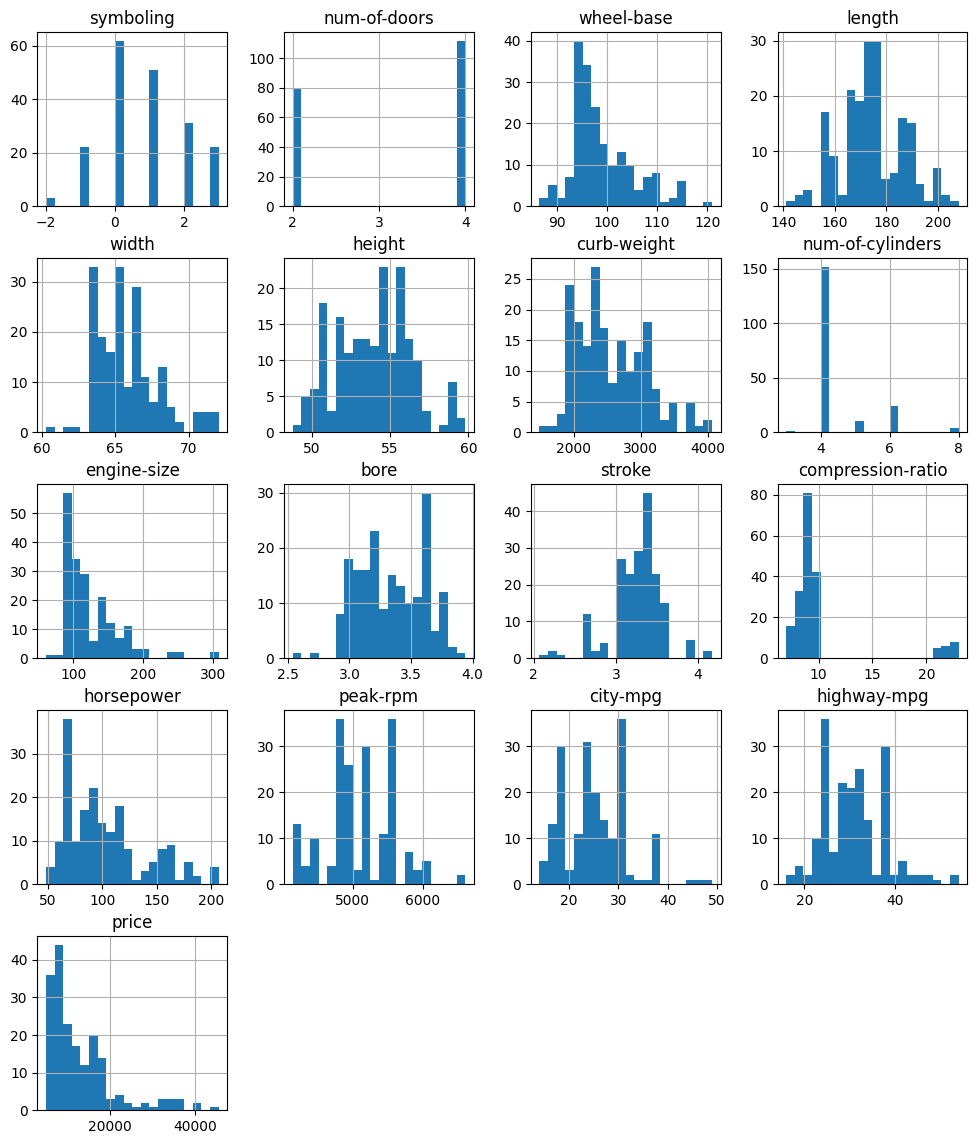

In [15]:
# Visual inspection of numerical variables
plt.rcParams['figure.figsize'] = [12, 14]
_ = car_df.hist(bins=20)
# all the features seem to be more or less well behaved except for the price which is skewed
# but this is not a problem because we will not using price during the clustering

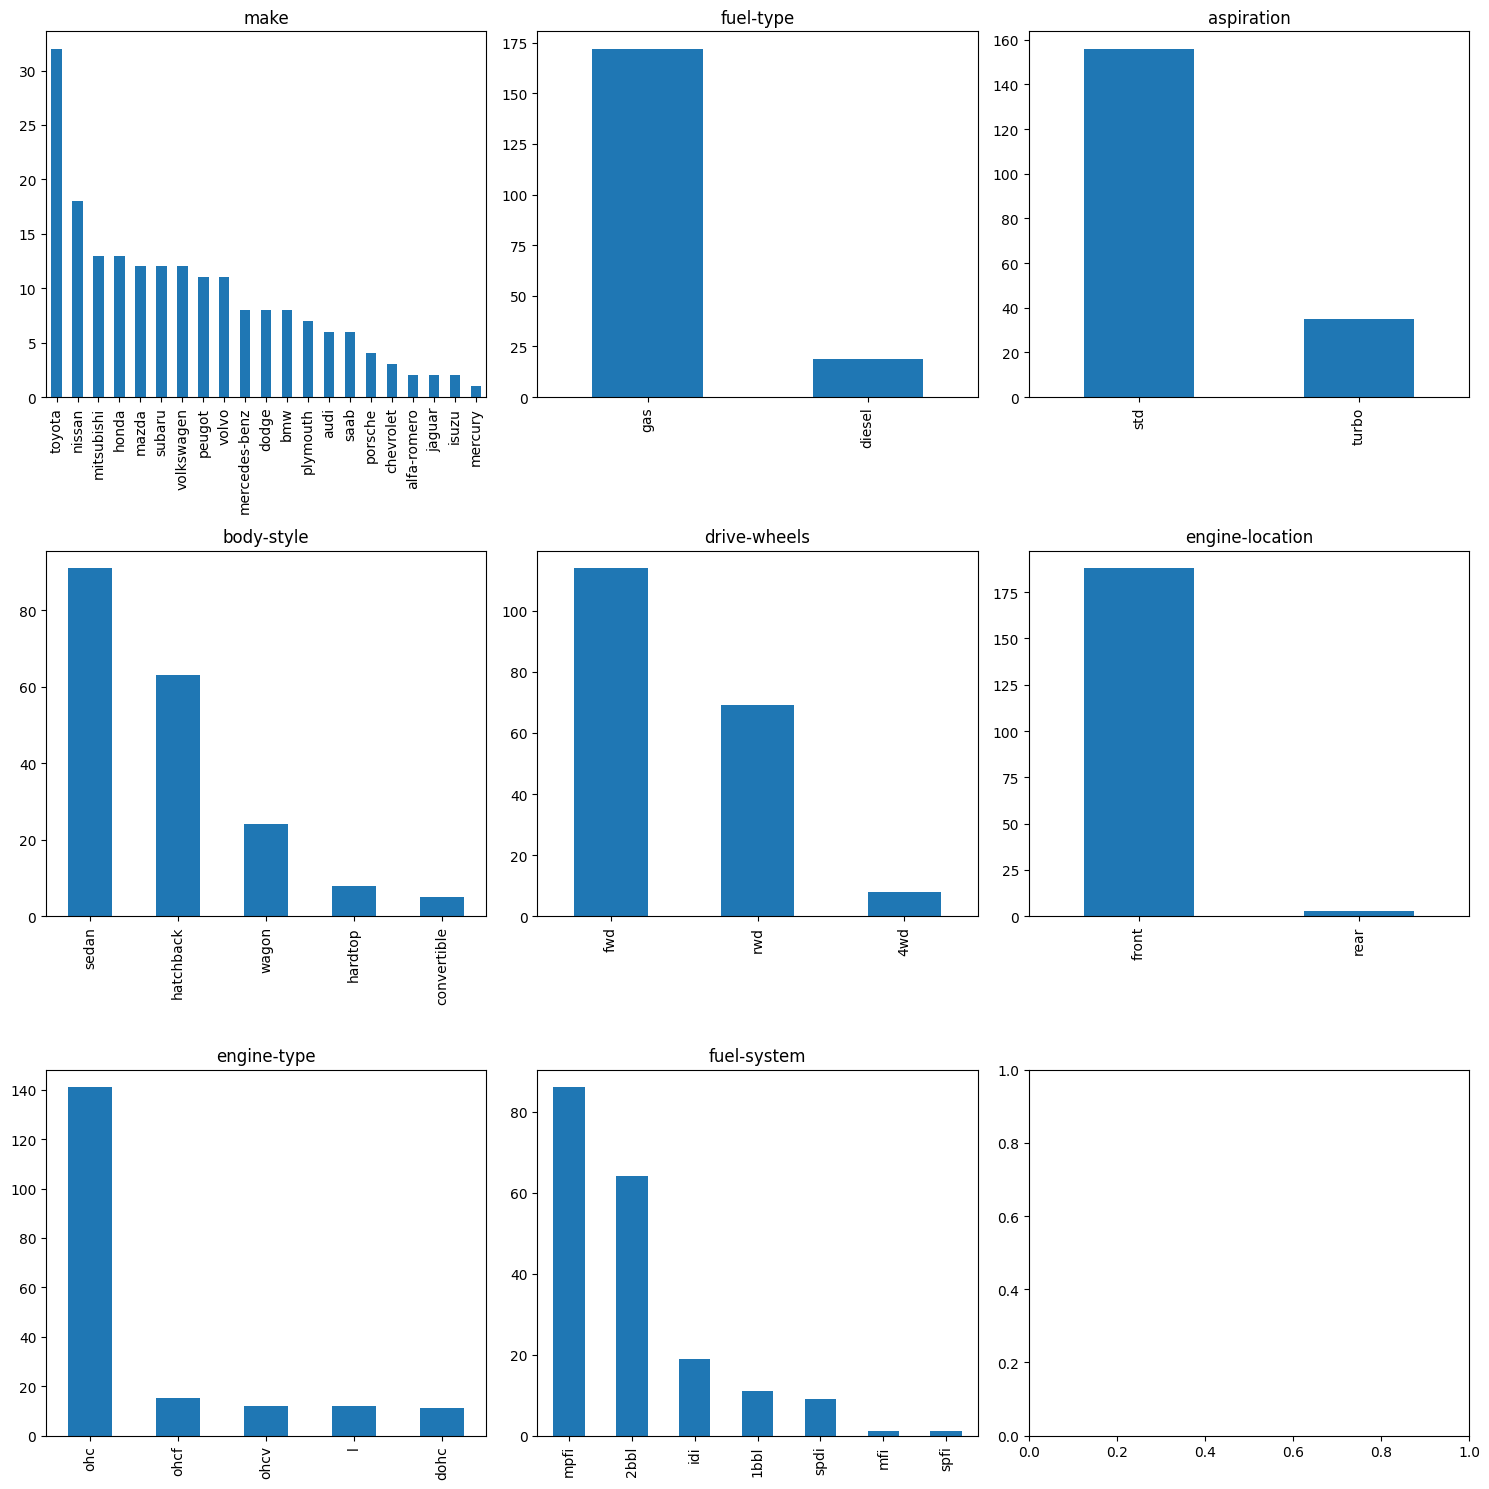

In [16]:
# Plot categorical columns
num_plots = len(categ_cols)

# Determine number of rows needed for the grid
num_rows = math.ceil(num_plots / 3.0)

# Create subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Flatten the axes array if there's more than one row
axs = axs.flatten()

# Plot the data
for i, column in enumerate(categ_cols):
    ax = axs[i]
    car_df[column].value_counts().plot(
        kind='bar',
        ax=ax,
        title=column,
        xlabel=''
    )

plt.tight_layout()

In [17]:
# in order to make the price column easier to use with our visualizations,
# we will replace specific prices with price ranges
# Auto-create price bins
bins = np.linspace(car_df['price'].min(), car_df['price'].max(), num=5)
bins
# here is the suggestion by the linspace function

array([ 5118. , 15188.5, 25259. , 35329.5, 45400. ])

In [18]:
# since we know that price is skewed and that majority of cars have a lower prices,
# we have to adjust these bins in order to create higher number of bins in the lower price range
# Customize price bins
custom_bins = [ 5000 , 10000,  15188,  25259 , 35329,  45500]

In [19]:
# Bin the price so we can easily plot prices
# on the dendrogram
car_sec_info = car_df.copy()
car_sec_info['price_bins'] = pd.cut(car_sec_info['price'], custom_bins, labels=["P1", "P2", "P3", "P4", "P5"])

car_df = car_df.drop(columns='price')

In [21]:
# Number of cars per price bin
car_sec_info['price_bins'].value_counts()

,count
price_bins,
P1,95
P3,43
P2,37
P4,10
P5,6


In [23]:
# Get categorical and numerical columns
categ_cols = list(car_df.select_dtypes(include=['object']).columns)
num_cols = list(set(car_df.columns) - set(categ_cols))

categ_bool = [col in categ_cols for col in car_df.columns] # for Gower distance

In [24]:
# Scale numerical columns
scaler = StandardScaler()
car_df[num_cols] = scaler.fit_transform(car_df[num_cols])

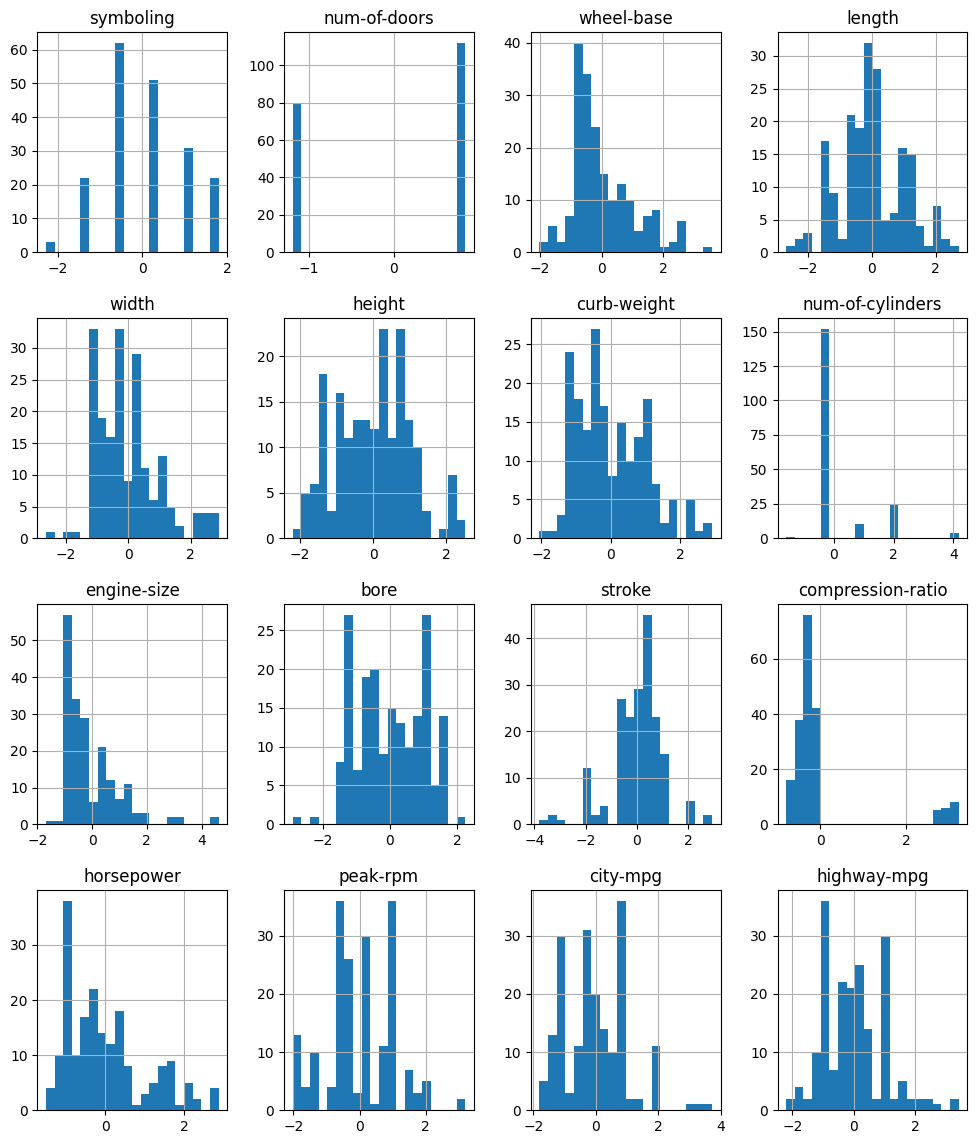

In [25]:
# Visual inspection of numerical variables
plt.rcParams['figure.figsize'] = [12, 14]
_ = car_df.hist(bins=20)

In [26]:
# Encode categorical variables
ord_enc = OrdinalEncoder()
car_df[categ_cols] = ord_enc.fit_transform(car_df[categ_cols])

### Perform clustering based on gower distance



In [31]:
# Calculate distance based on both, numerical and categorical variables
gow_distances = gower.gower_matrix(car_df, cat_features=categ_bool)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/usr/local/lib/python3.10/dist-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

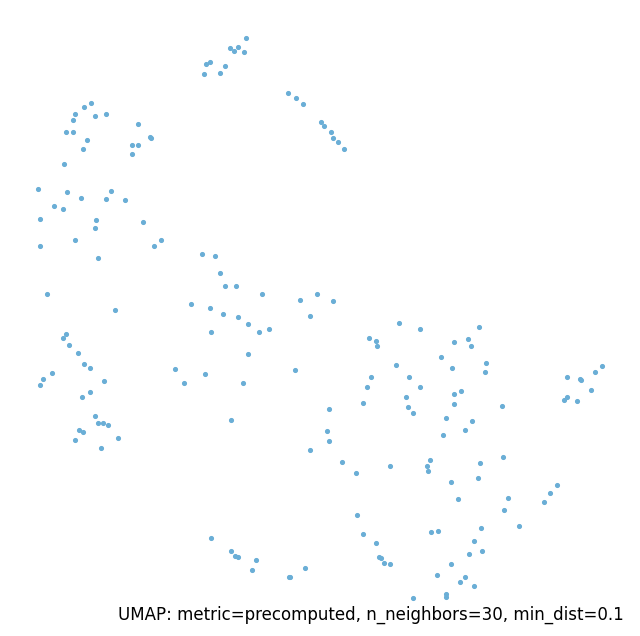

In [32]:
# Perfrom UMAP dimensionality reduction
umap_obj = umap.UMAP(n_neighbors=30, metric='precomputed')
embedding_mtx = umap_obj.fit_transform(gow_distances)

uplot.points(umap_obj)
# the UMAP embedding isn't too informative

/usr/local/lib/python3.10/dist-packages/datashader/transfer_functions/__init__.py:332: RuntimeWarning: invalid value encountered in divide
  scaled_data = (data - span[0])/(span[1] - span[0])


<Axes: >

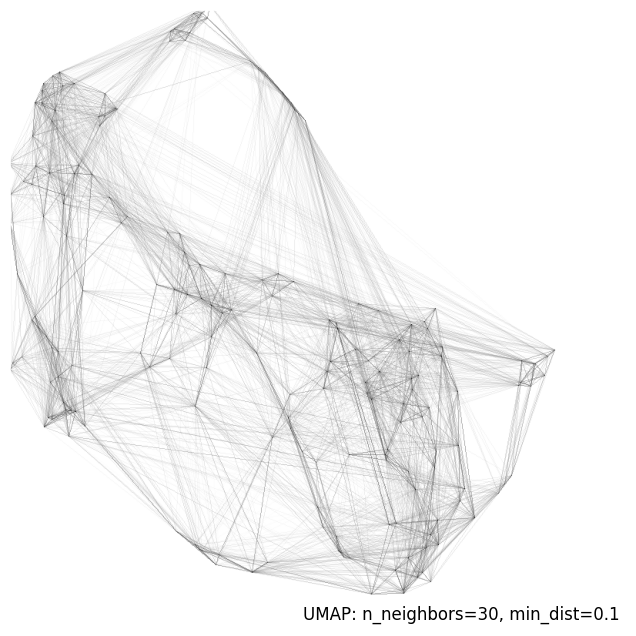

In [33]:
umap.plot.connectivity(umap_obj, show_points=True)
# everything is nicely interconnected

<Axes: title={'center': 'Colored by RGB coords of PCA embedding'}>

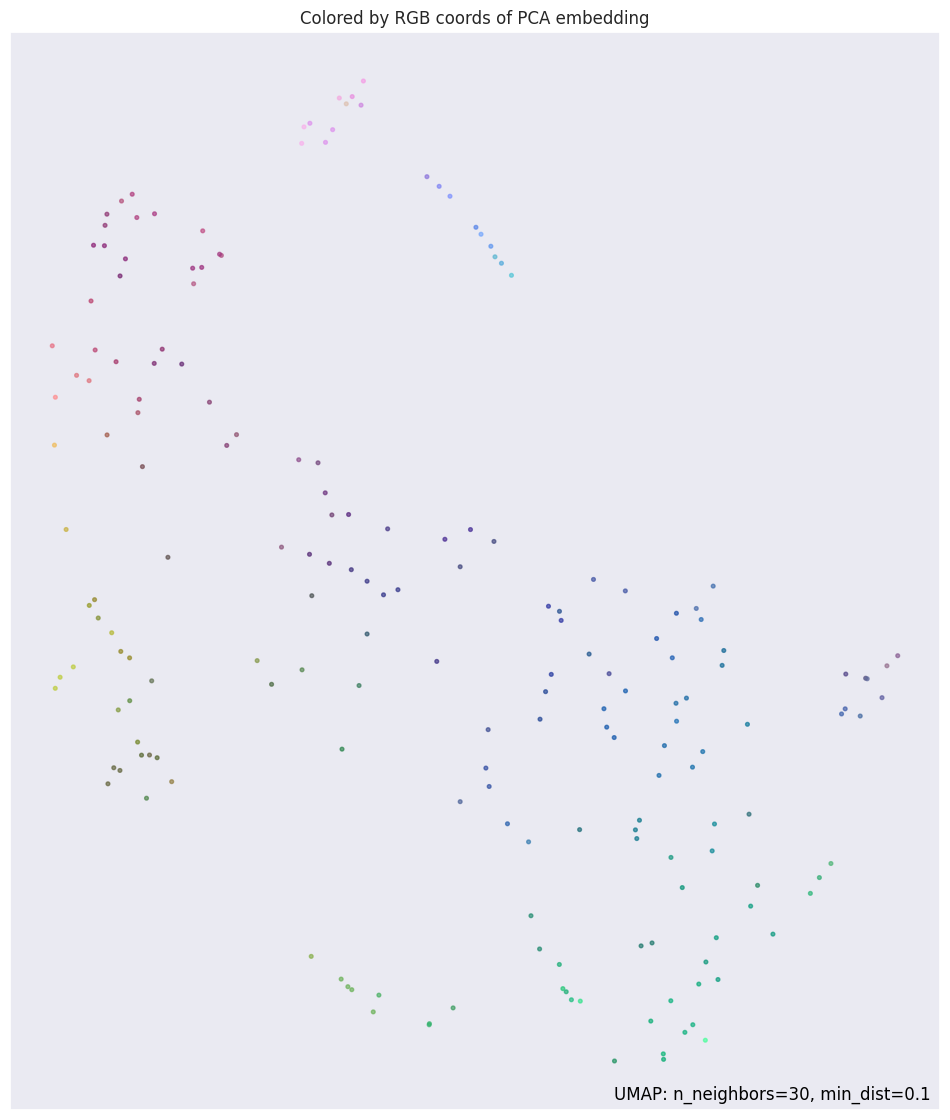

In [34]:
umap.plot.diagnostic(umap_obj, diagnostic_type='pca')
# transitions of colors are more or less smooth

In [35]:
# Create dendrogram based on precomputed distance
gow_distances_condens = squareform(gow_distances)

linkage_matrix = linkage(
    gow_distances_condens,
    method='average'
)

In [36]:
cophenetic_corr(
    linkage_matrix=linkage_matrix,
    data_mtx = gow_distances,
    distance_measure='precomputed'
)
# the dendrogram is usable

Cophenetic correlation : 0.7371196249213059


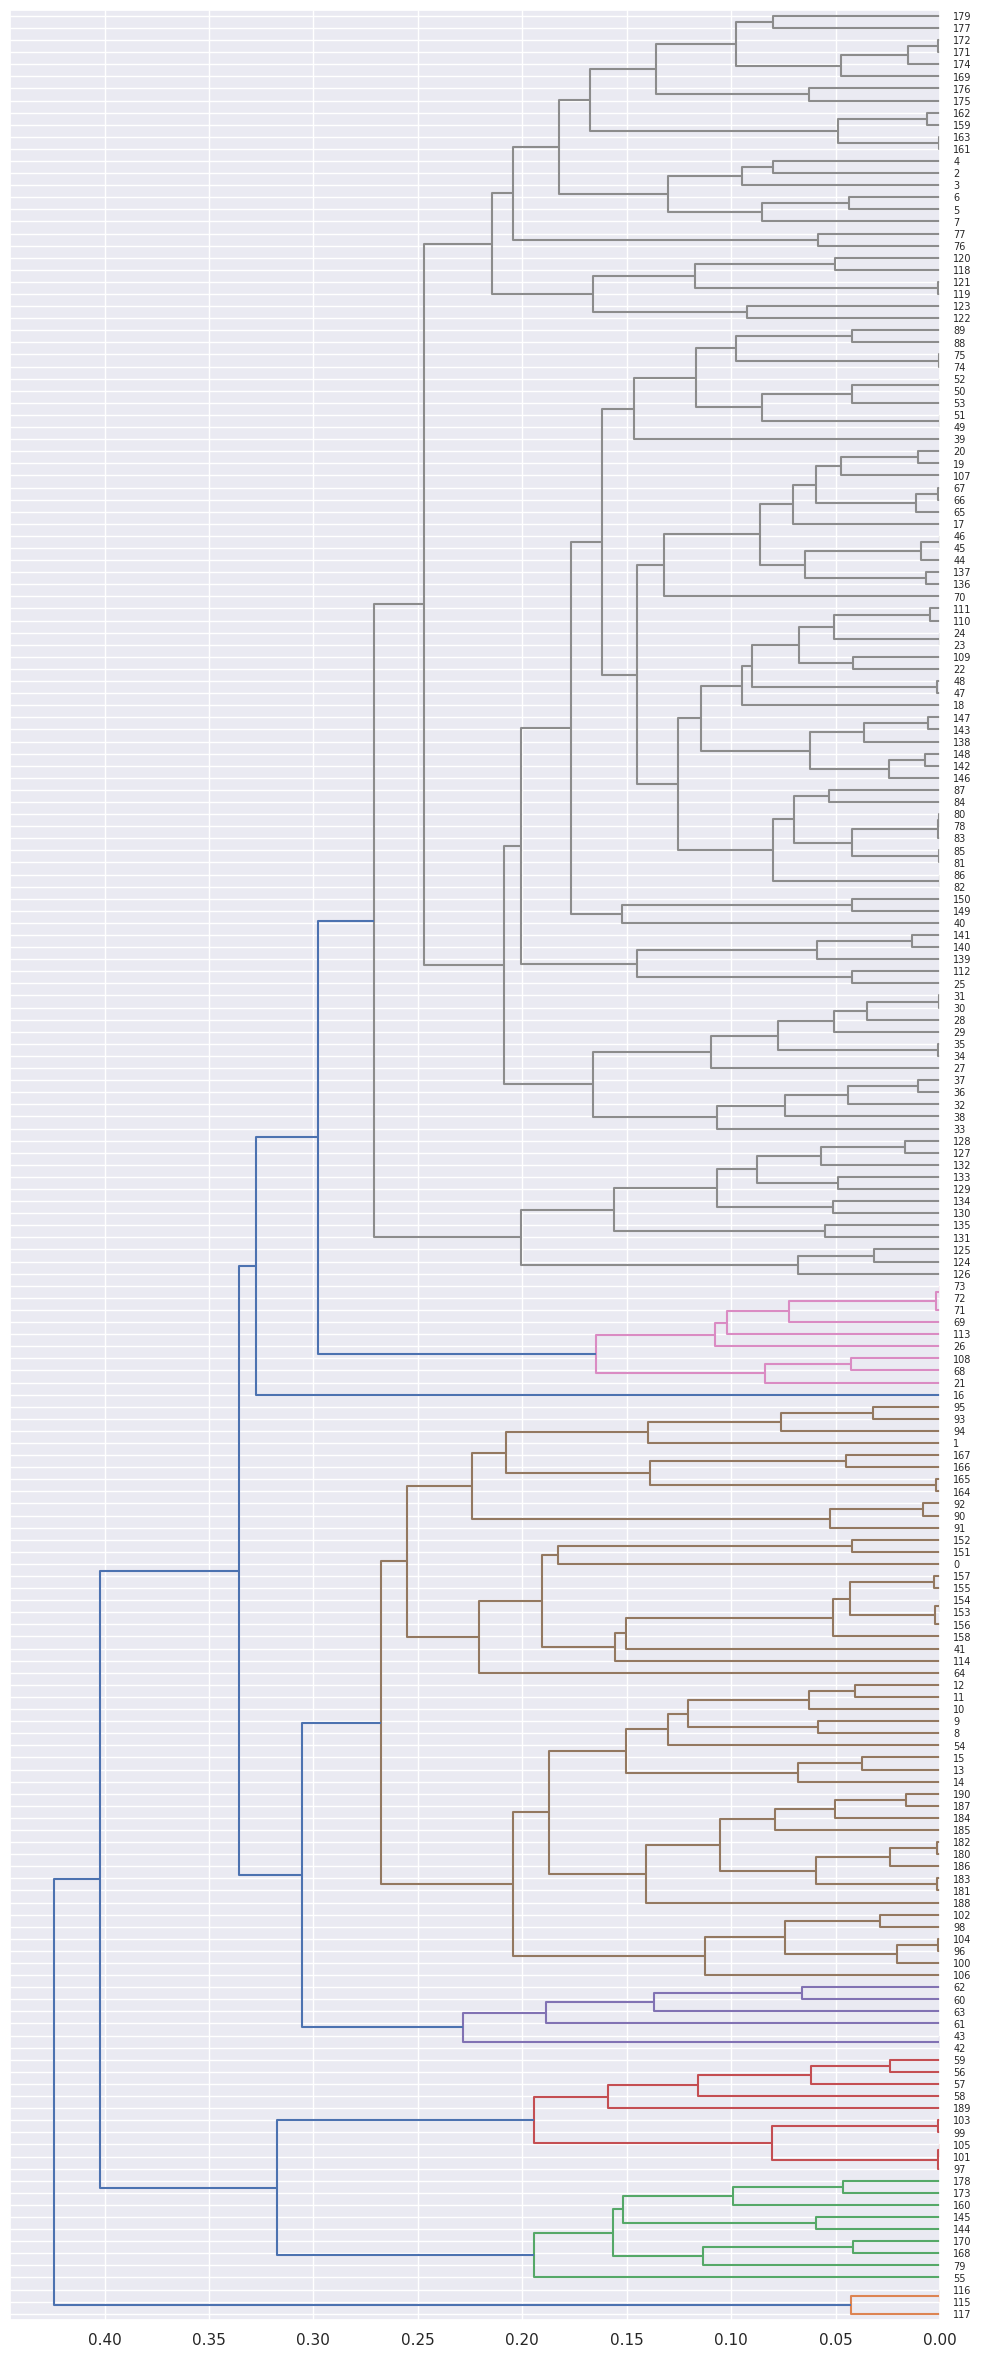

In [37]:
# Plot the dendrogram
plt.rcParams['figure.figsize'] = [12, 30]
_ = dendrogram(
    linkage_matrix,
    orientation='left',
    labels=car_df.index,
    leaf_font_size=7
)

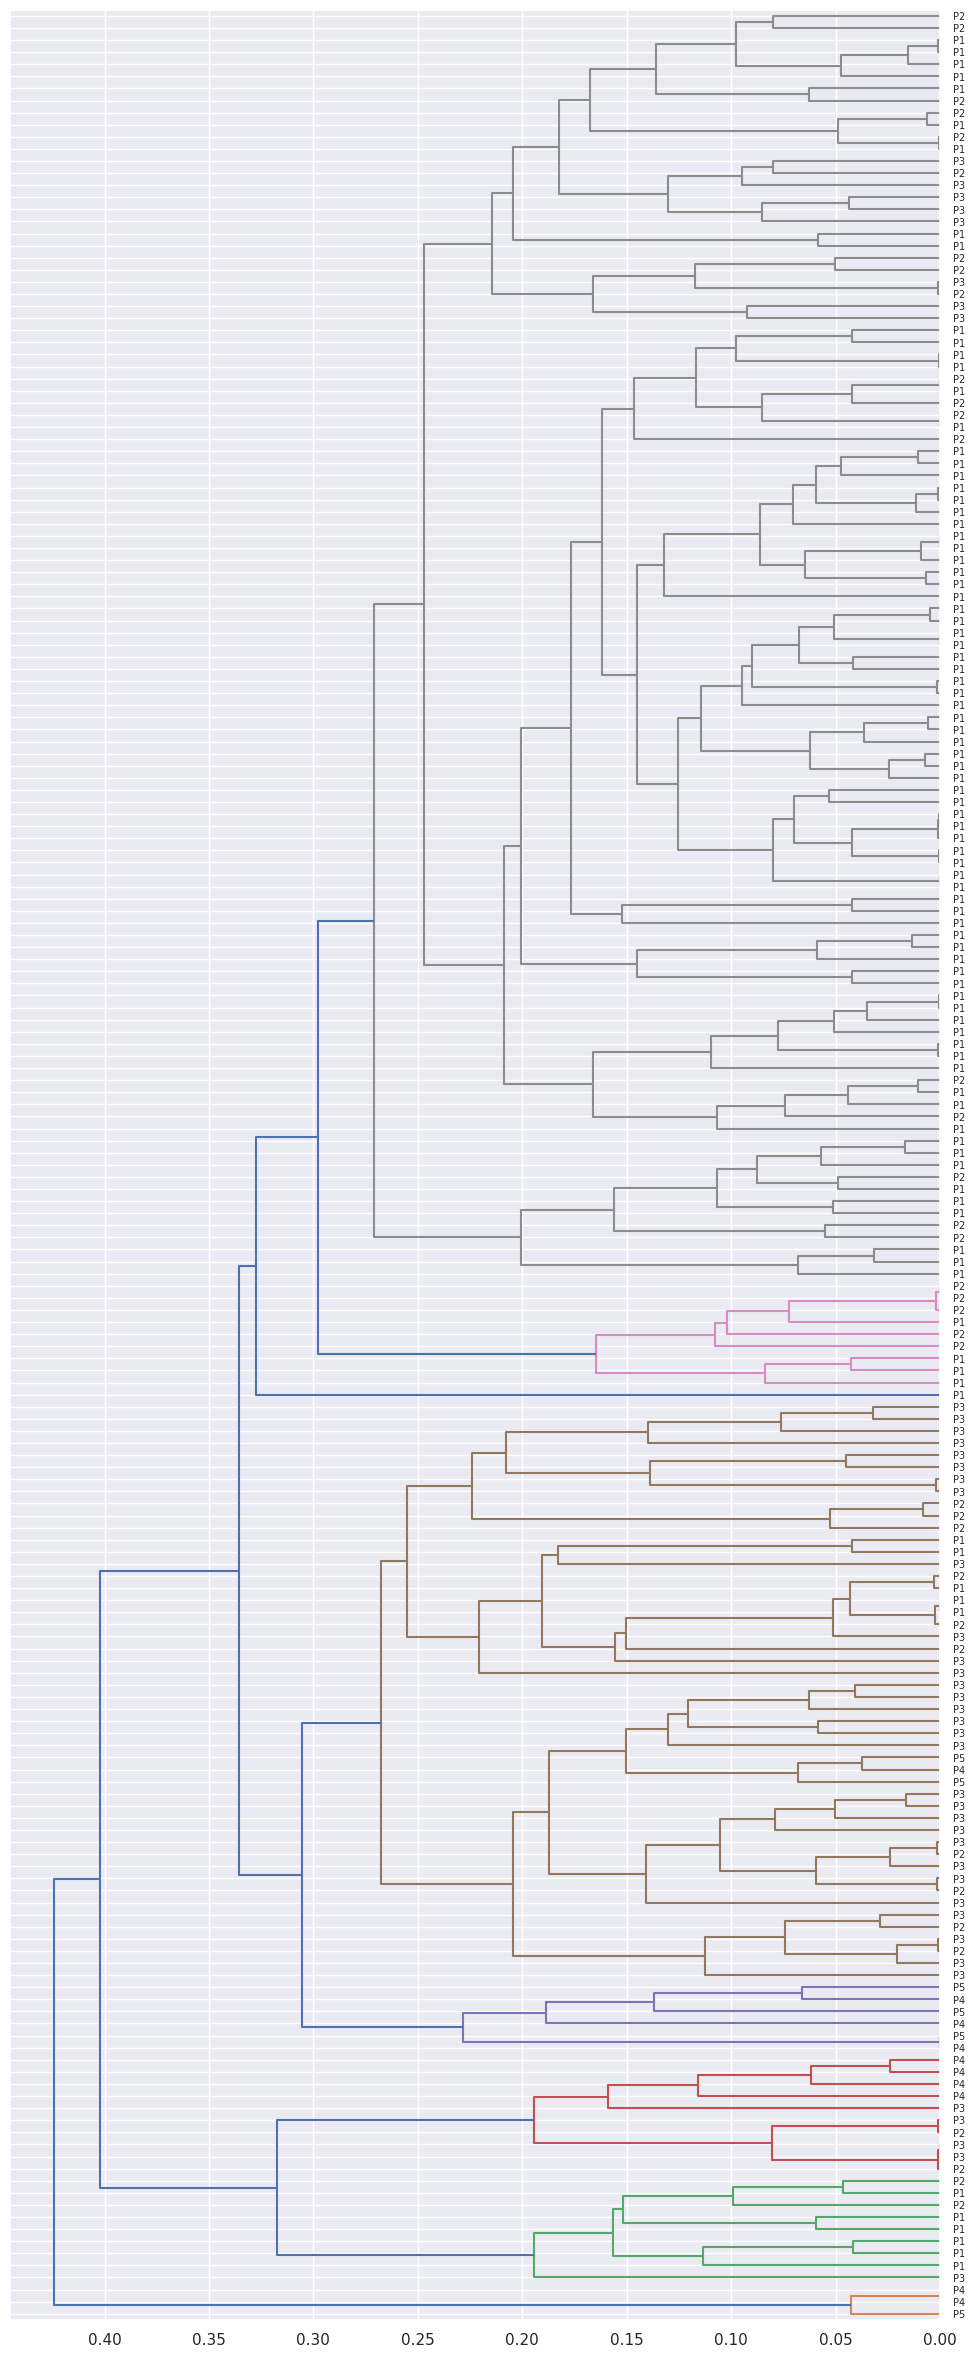

In [38]:
# Plot the dendrogram
plt.rcParams['figure.figsize'] = [12, 30]
_ = dendrogram(
    linkage_matrix,
    orientation='left',
    labels=car_sec_info['price_bins'].to_numpy(),
    leaf_font_size=7
)
# each group contains cars having similar price ranges

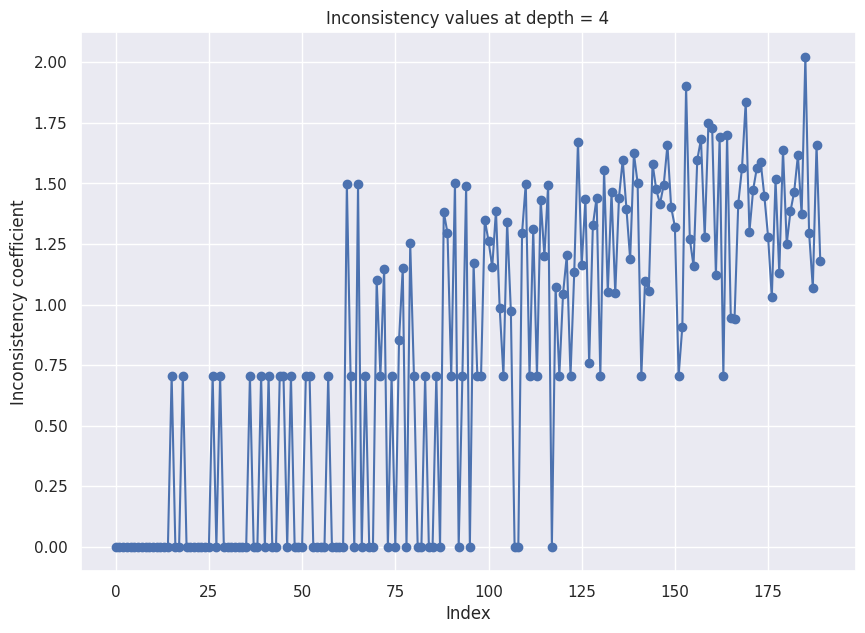

In [39]:
# Calculate inconsistence matrix
depth=4
incosistent_mtx = inconsistent(linkage_matrix,depth)

# Plot inconsistency scores for given depth
plt.figure(figsize=(10, 7))
plt.plot(incosistent_mtx[:,-1])
plt.scatter(range(incosistent_mtx.shape[0]),incosistent_mtx[:,-1])
plt.title('Inconsistency values at depth = {}'.format(depth))
plt.xlabel('Index')
plt.ylabel('Inconsistency coefficient')
plt.show()

In [40]:
# Perform clustering based on inconsistency
# and print clusters
clusters = fcluster(Z=linkage_matrix, t=1.6, criterion='inconsistent', R=incosistent_mtx)
clusters

array([13, 15, 31, 31, 31, 31, 31, 31,  9,  9,  9,  9,  9,  9,  9,  9, 34,
       26, 25, 26, 26, 16, 25, 25, 25, 23, 17, 22, 22, 22, 22, 22, 21, 21,
       22, 22, 21, 21, 21, 28, 24, 11,  4,  4, 26, 26, 26, 25, 25, 28, 28,
       28, 28, 28,  9,  2,  3,  3,  3,  3,  4,  4,  4,  4, 14, 26, 26, 26,
       16, 17, 27, 17, 17, 17, 28, 28, 30, 30, 25,  2, 25, 25, 25, 25, 25,
       25, 25, 25, 28, 28, 15, 15, 15, 15, 15, 15,  5,  3,  5,  3,  5,  3,
        5,  3,  5,  3,  5, 26, 16, 25, 25, 25, 23, 17, 12,  1,  1,  1, 29,
       29, 29, 29, 29, 29, 18, 18, 18, 20, 20, 20, 20, 19, 20, 20, 20, 19,
       26, 26, 25, 23, 23, 23, 25, 25,  2,  2, 25, 25, 25, 24, 24, 13, 13,
       10, 10, 10, 10, 10, 10, 32,  2, 32, 32, 32, 15, 15, 15, 15,  2, 33,
        2, 33, 33,  2, 33, 33, 33, 33,  2, 33,  6,  6,  6,  6,  7,  7,  6,
        7,  8,  3,  7], dtype=int32)

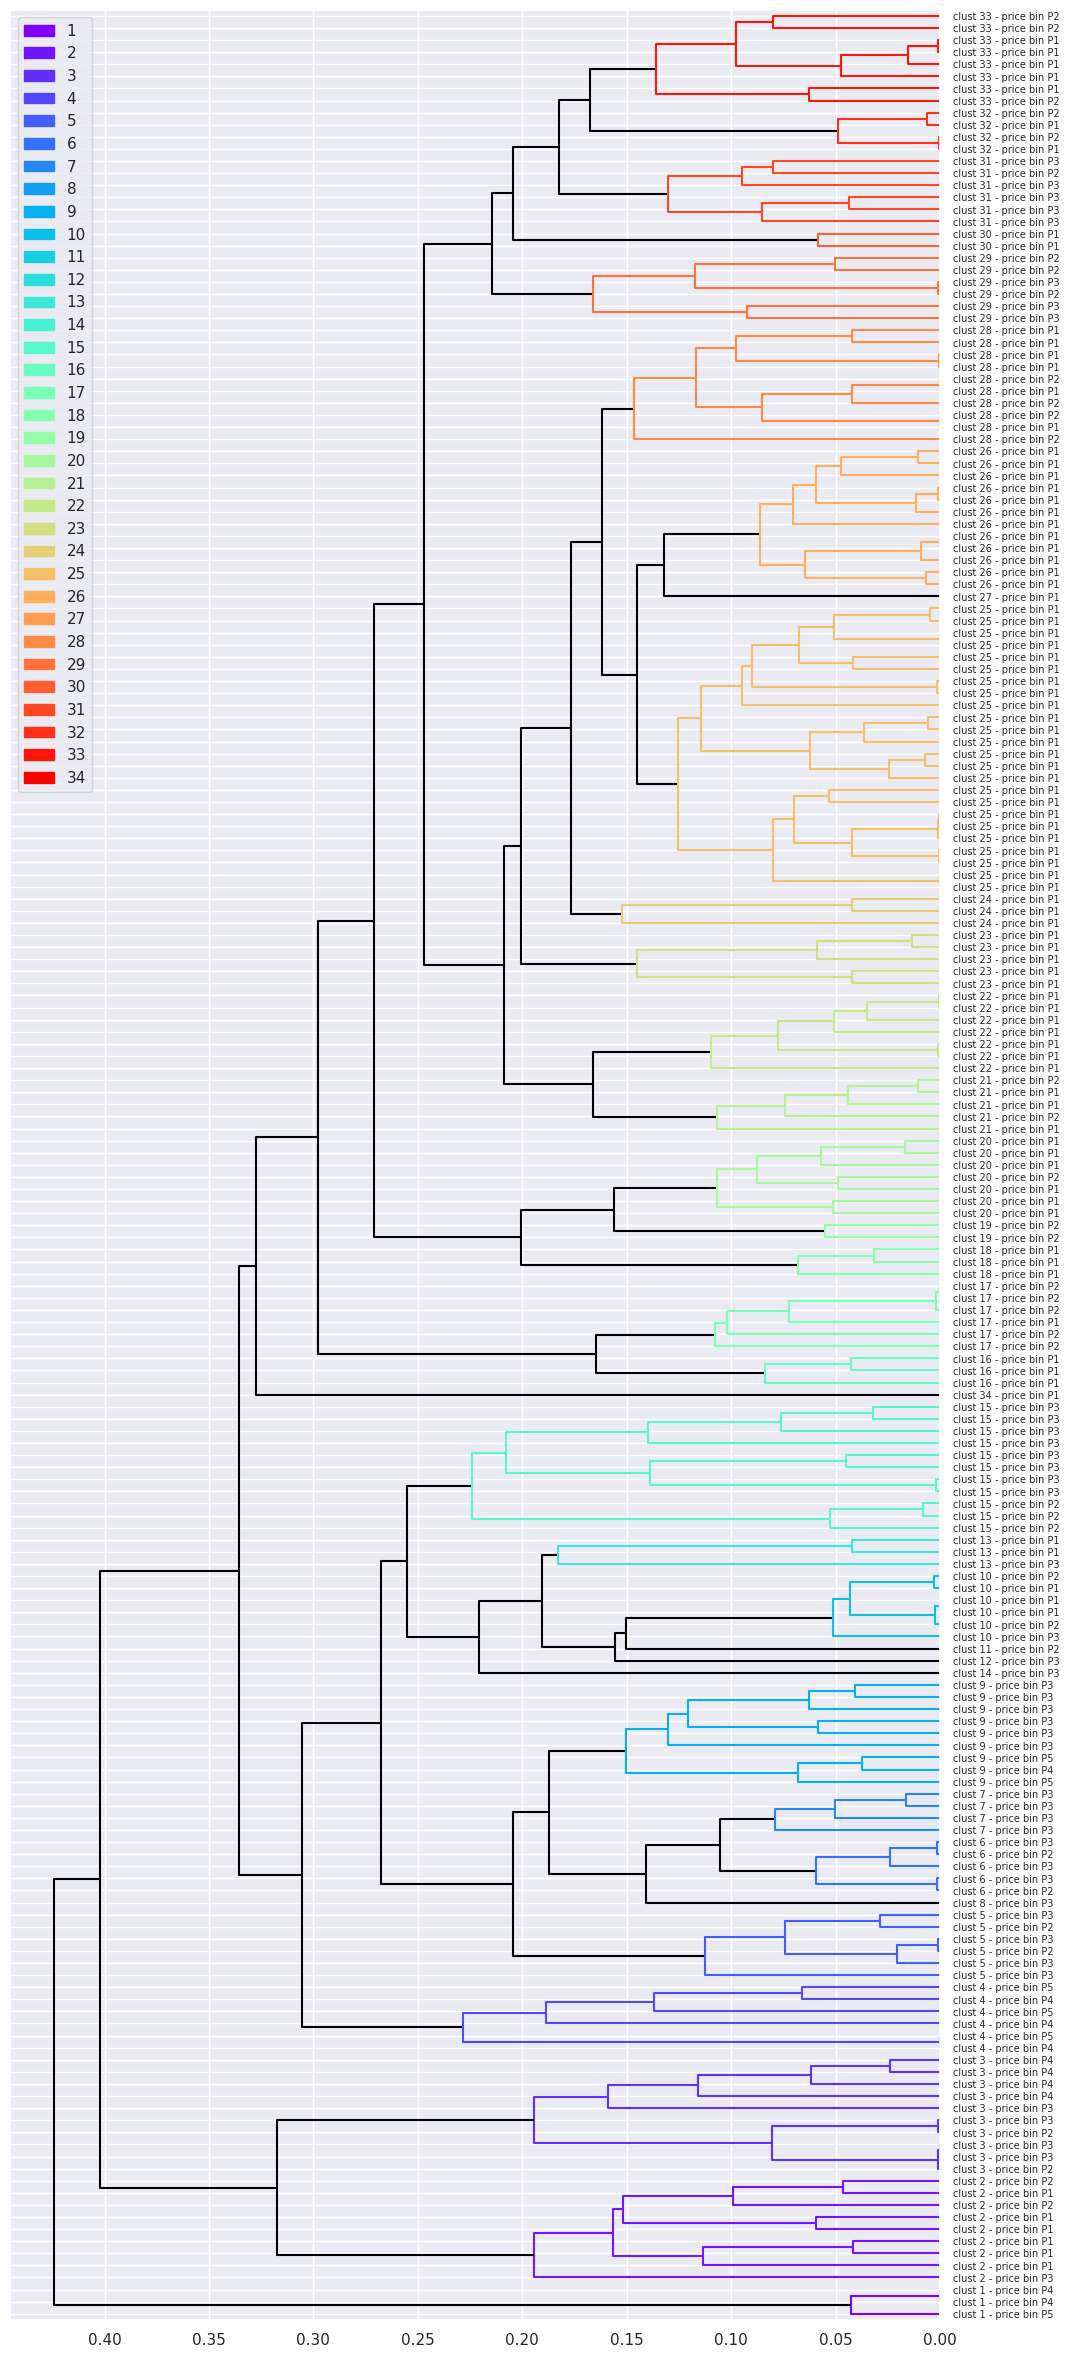

In [41]:
labels = [
    'clust {} - price bin {}'.format(clust, price)
    for clust, price in zip(clusters, car_sec_info['price_bins'].to_numpy())
]

dendr_colors = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=car_df,
    clusters=clusters,
    leaf_font_size=7,
    labels=labels
)
# some clusters are very small

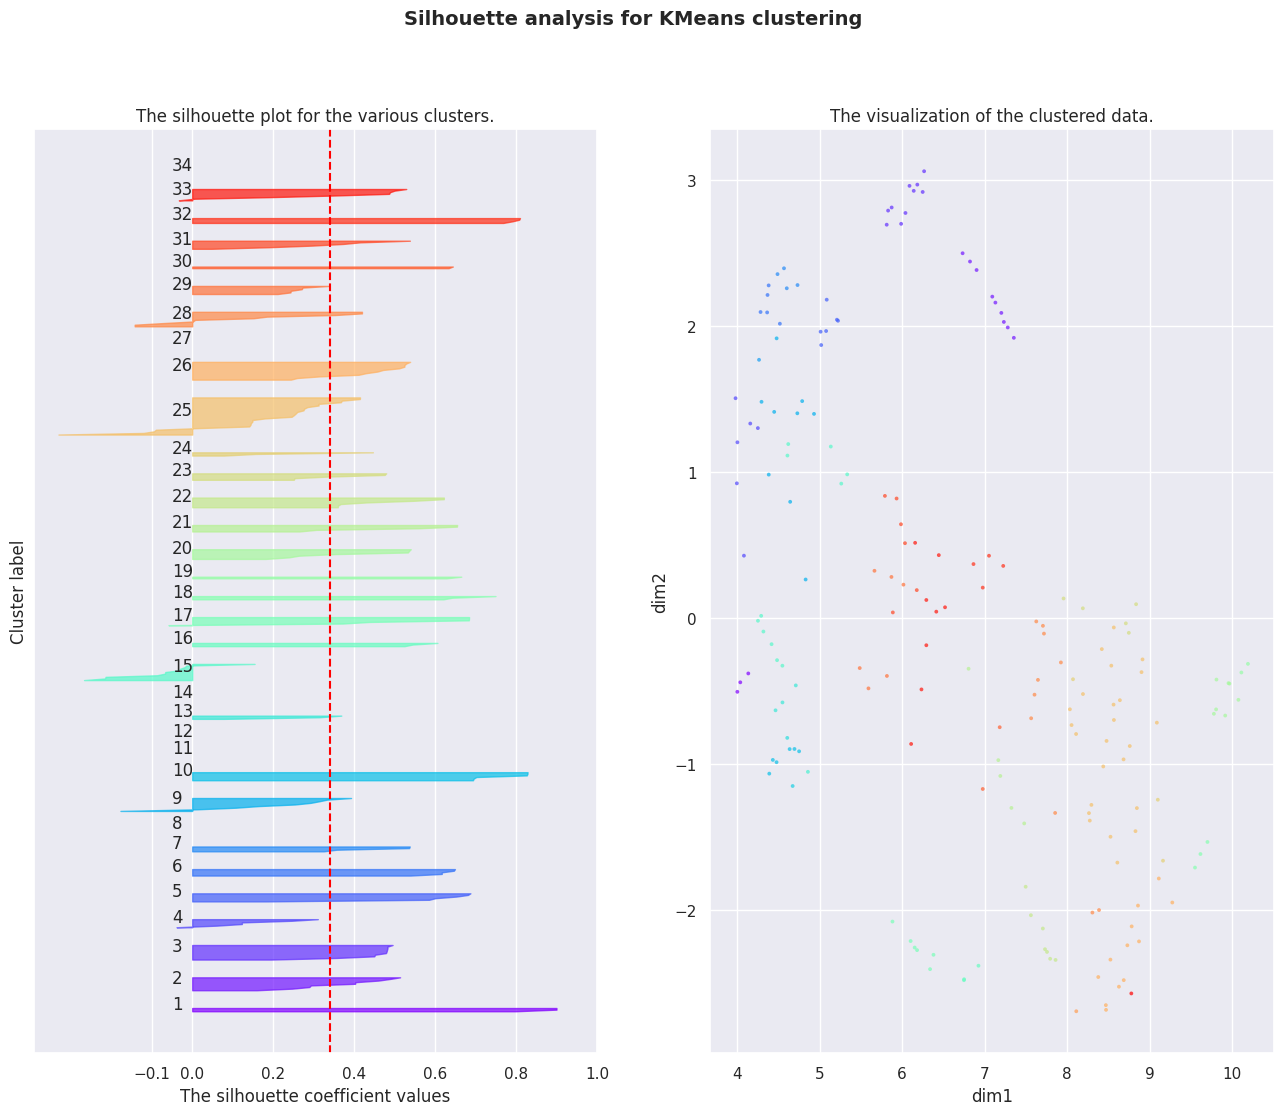

In [42]:
_ = plot_silouethes_agglomer(
    data_df=gow_distances,
    clusters=clusters,
    dendr_colors=dendr_colors,
    embedding_mtx=embedding_mtx,
    distance_measure='precomputed',
    figsize=(16,12)
)
# majority of clusters seem stable
# in the right plot, we cannot make any sound conclusions
# however, we can observe that data points having same color are close to each other

In [43]:
car_sec_info['cluster'] = clusters
clust_size = car_sec_info['cluster'].value_counts().sort_index(ascending=False)
clust_size
# we have clusters of variable sizes

,count
cluster,
34,1
33,8
32,4
31,6
30,2
29,6
28,10
27,1
26,12


In [44]:
keep_clust = clust_size[clust_size>2].index.to_list()
keep_clust

[33,
 32,
 31,
 29,
 28,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 18,
 17,
 16,
 15,
 13,
 10,
 9,
 7,
 6,
 5,
 4,
 3,
 2,
 1]

Insurance risk rating of the vehicle, ranging from -3 (safest) to 3 (riskiest)


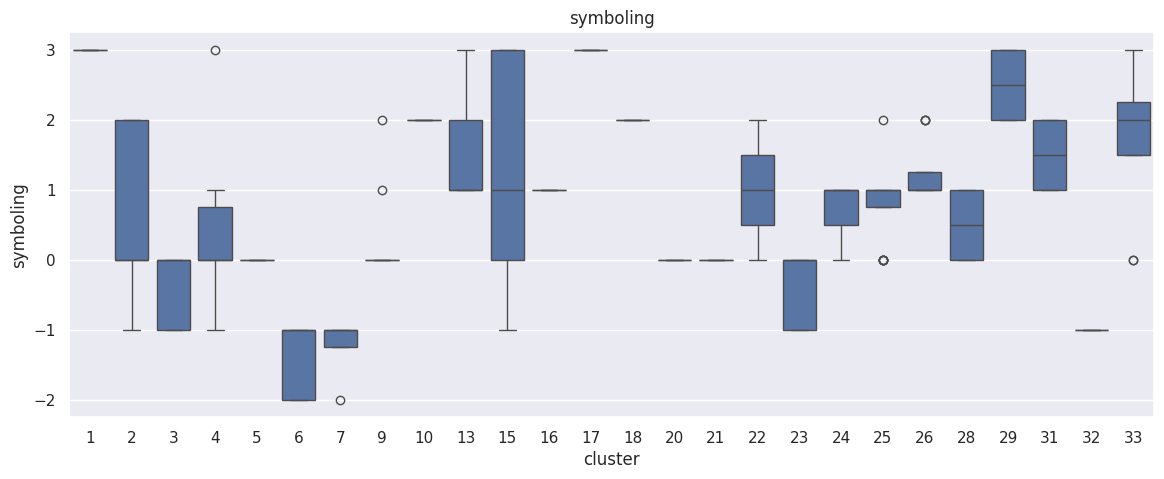

Brand or manufacturer of the car


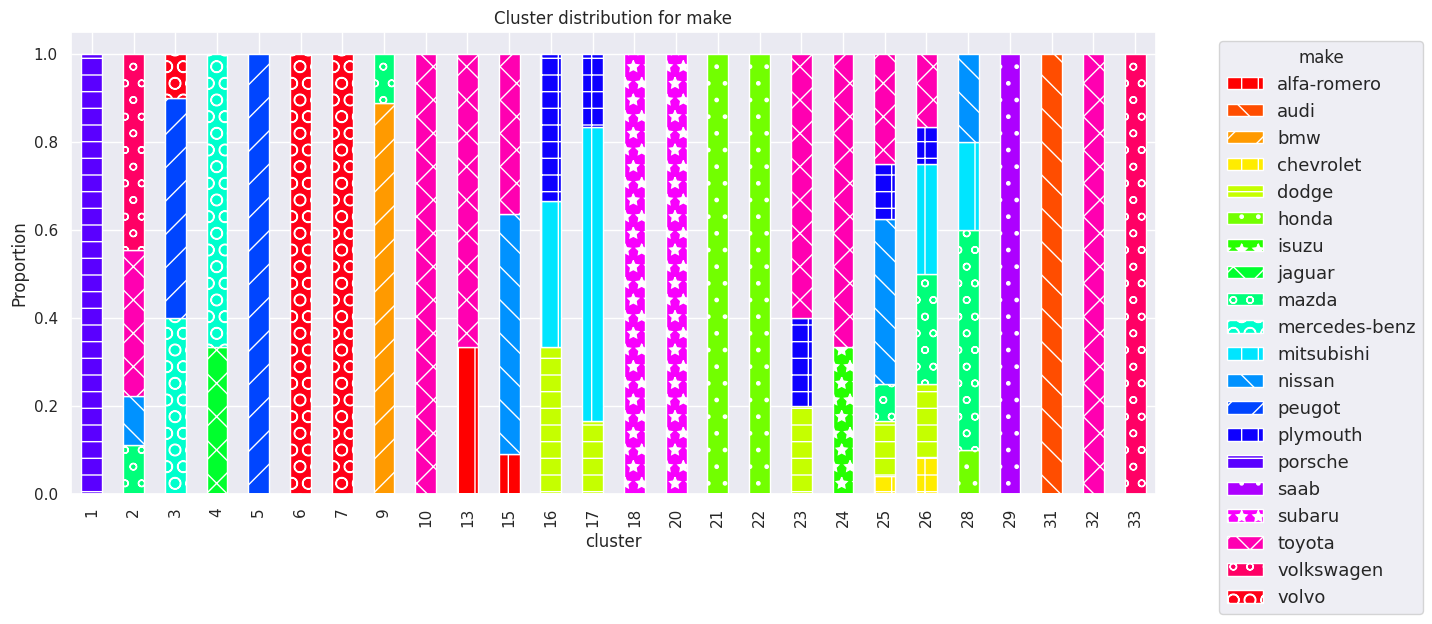

Type of fuel the car uses, such as diesel or gasoline


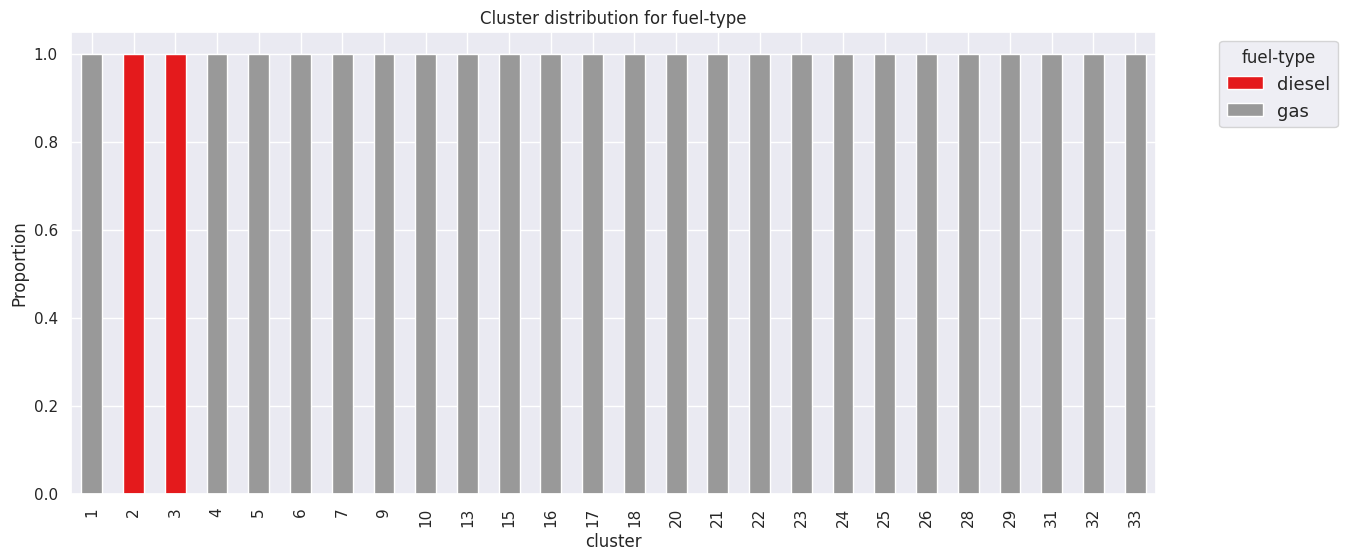

Method of air intake for the engine, either standard or turbocharged


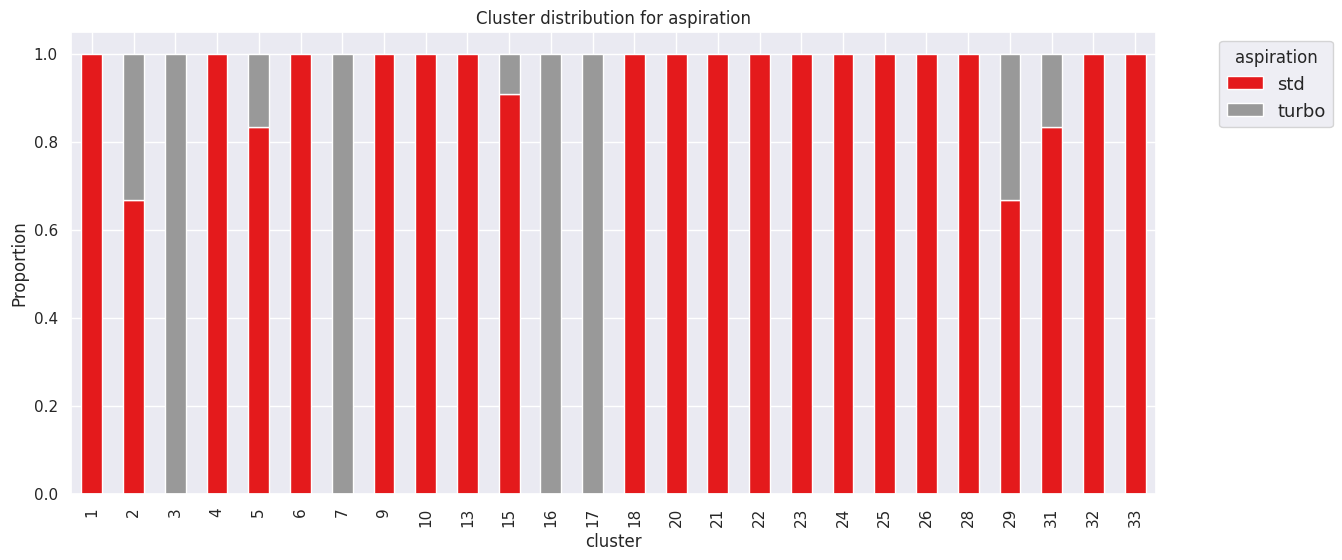

Number of doors the car has


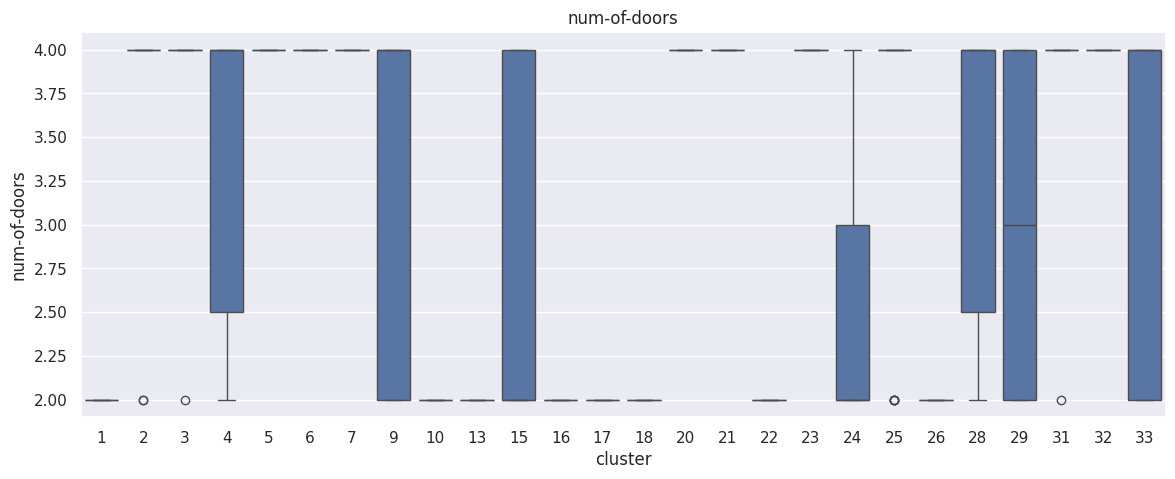

Design form of the car body, like sedan, hatchback, etc.


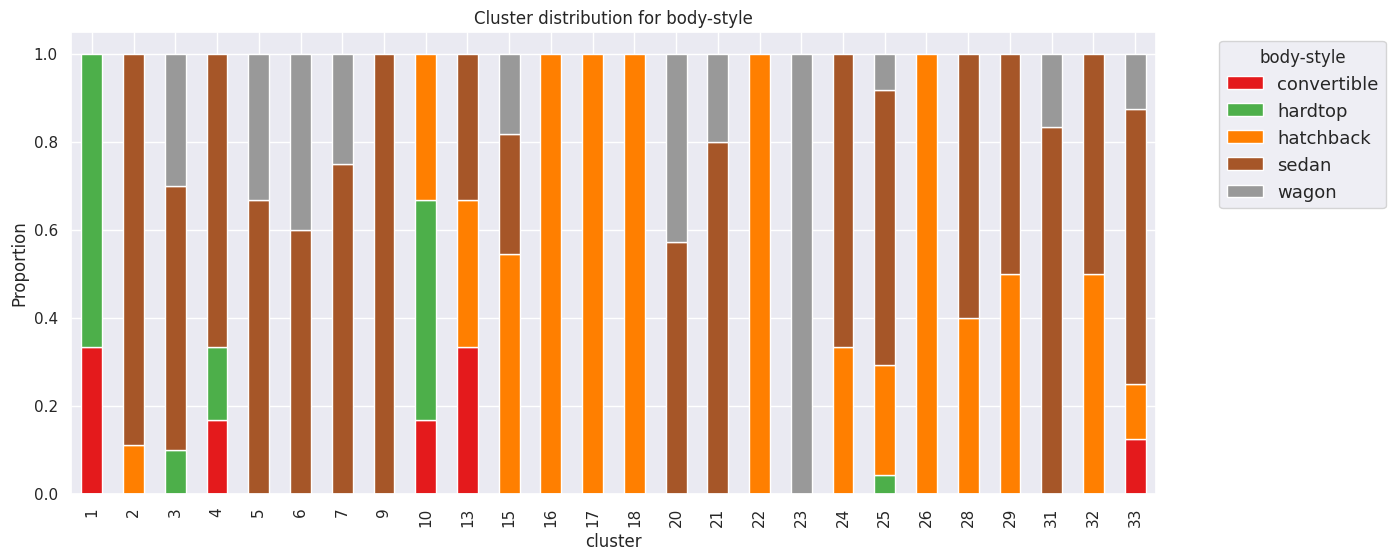

Type of drivetrain, indicating which wheels are powered (front, rear, or all)


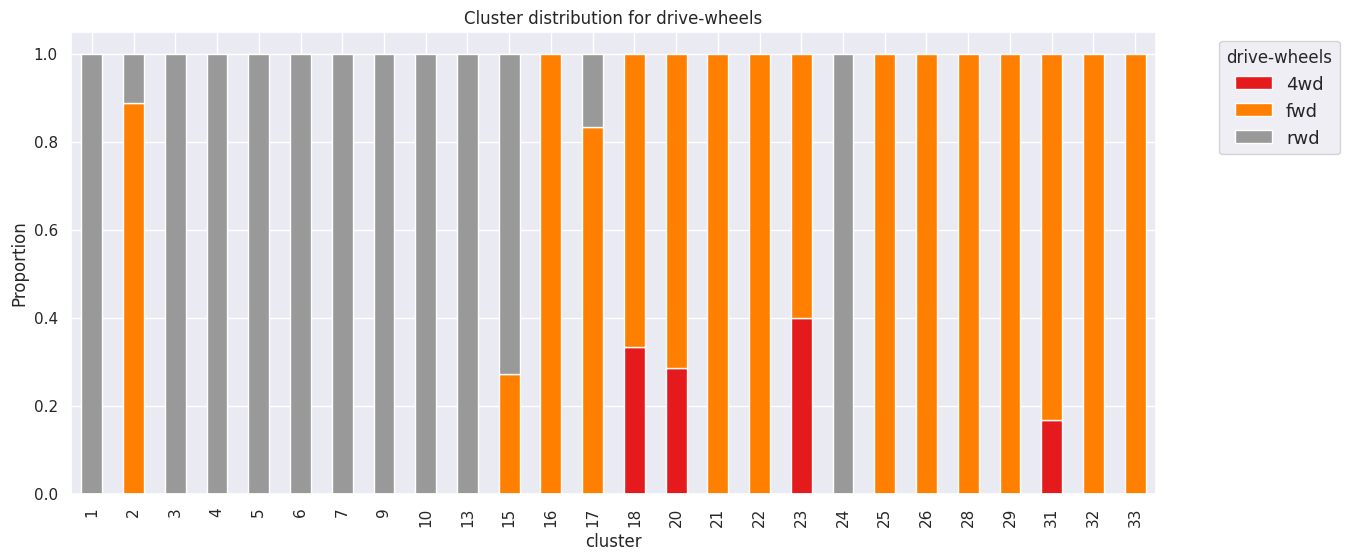

Position of the engine in the car, either front or rear


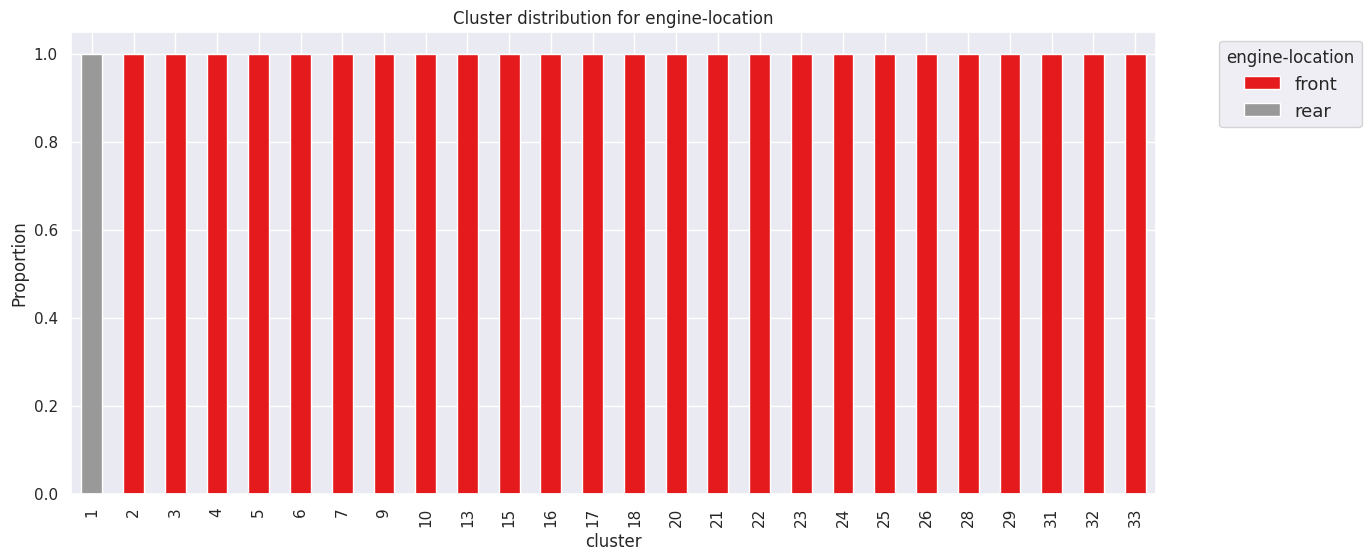

Distance between the front and rear wheels, measured in inches


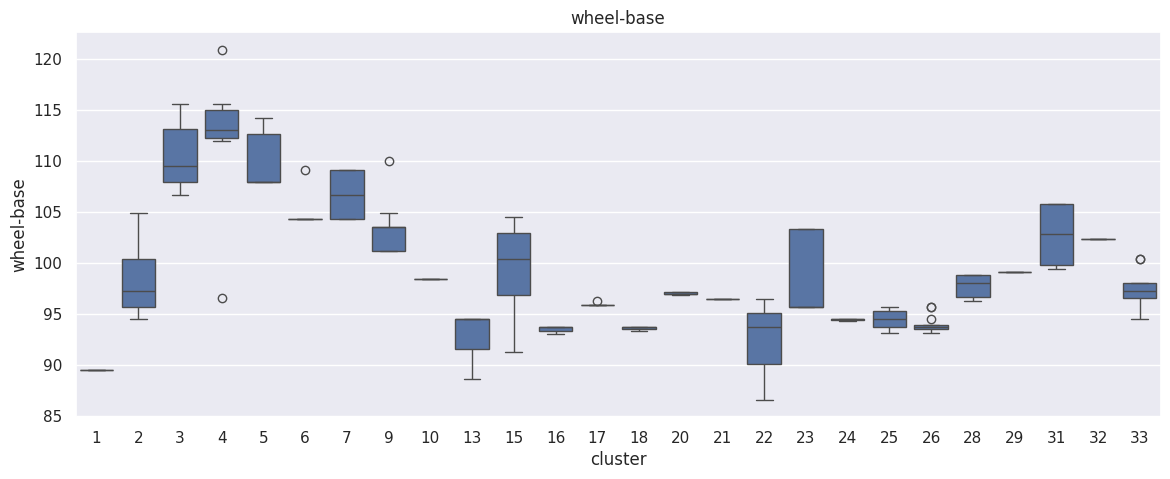

Overall length of the car, measured in inches


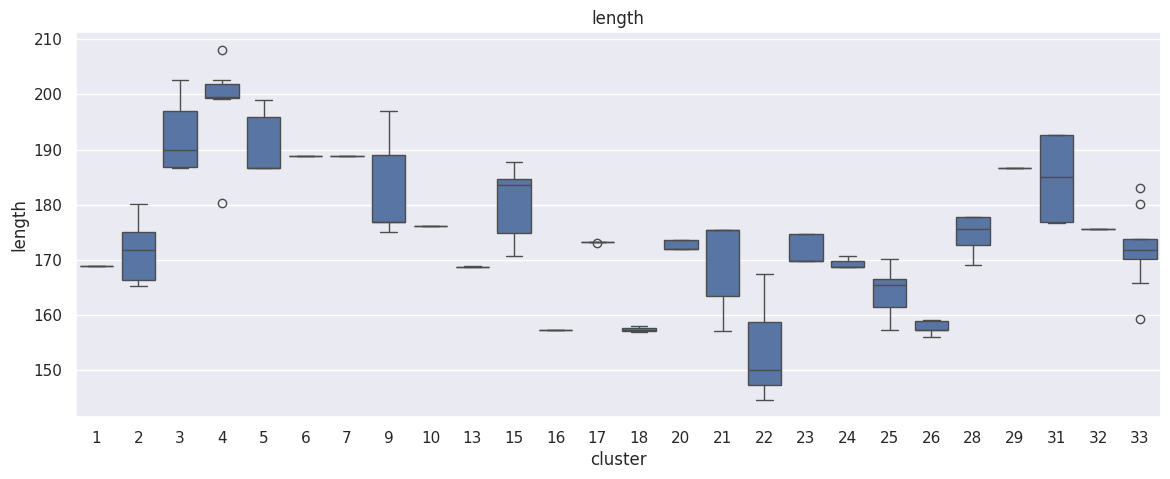

Overall width of the car, measured in inches


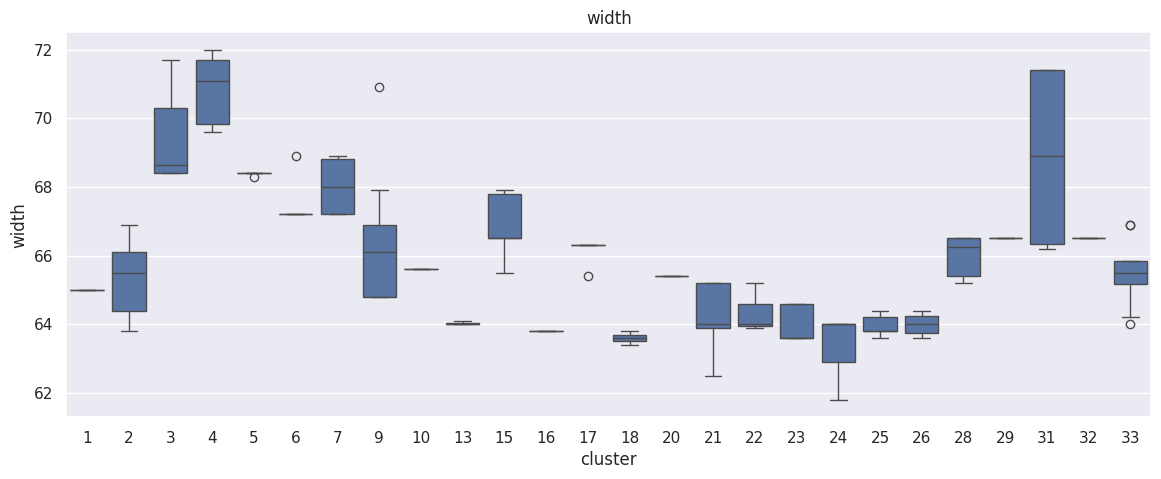

Overall height of the car, measured in inches


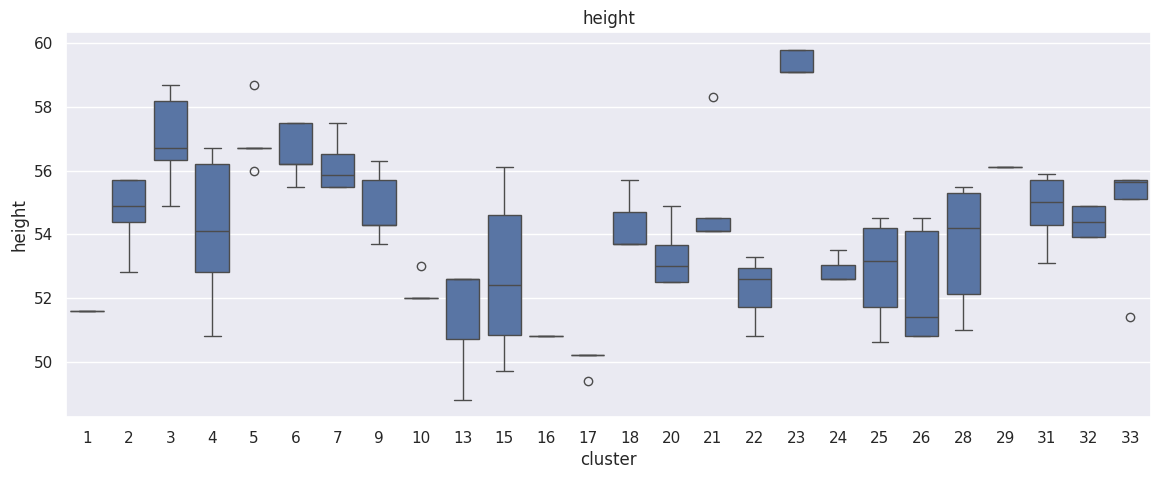

Weight of the car without any passengers or cargo, measured in pounds


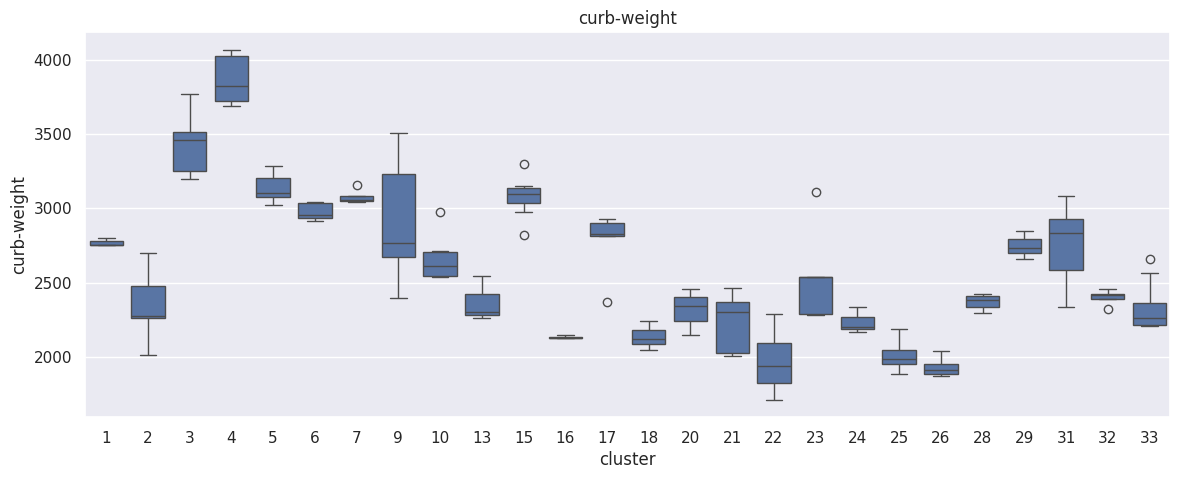

Configuration and design of the engine (e.g., OHC, OHCV)


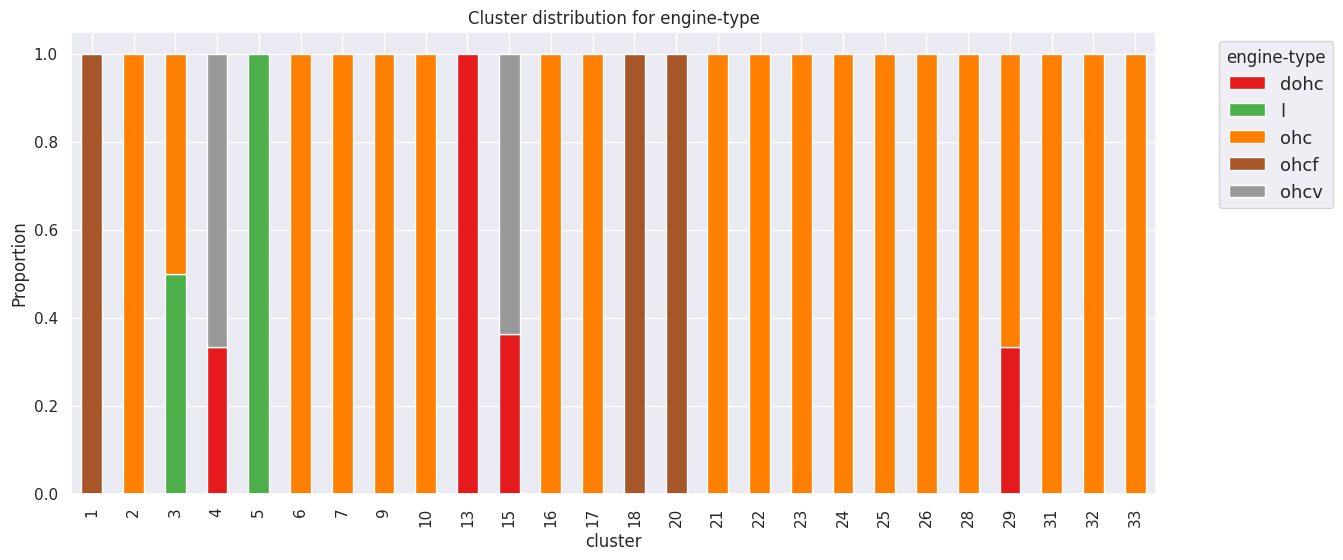

Total number of cylinders in the engine


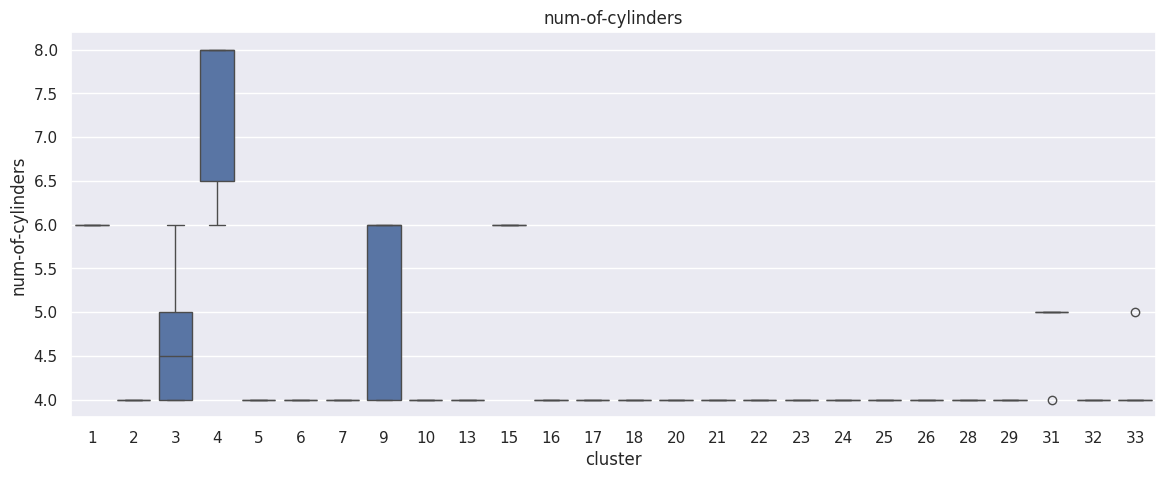

Displacement volume of the engine, measured in cubic centimeters


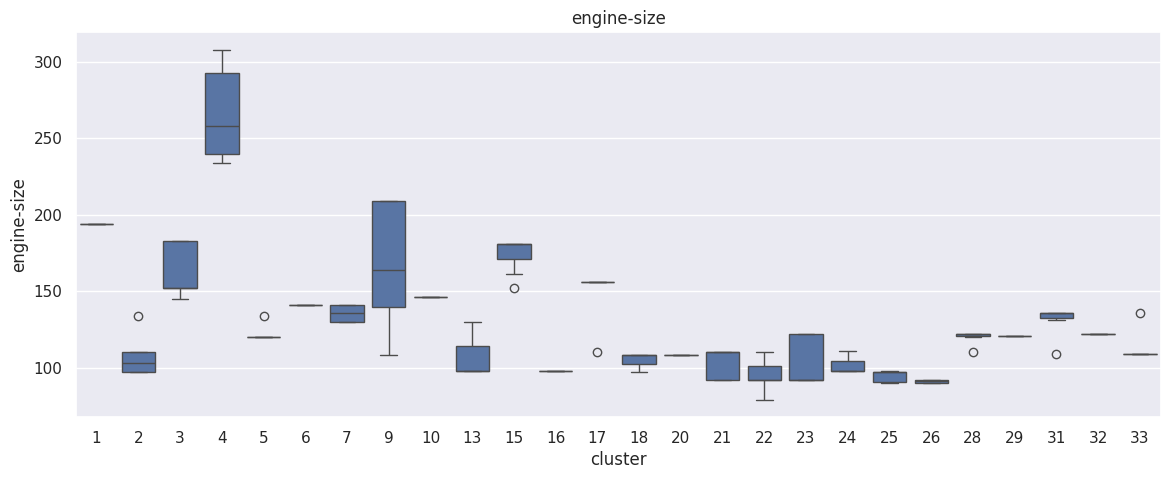

Mechanism or system for delivering fuel to the engine (e.g., MPFI, 2bbl)


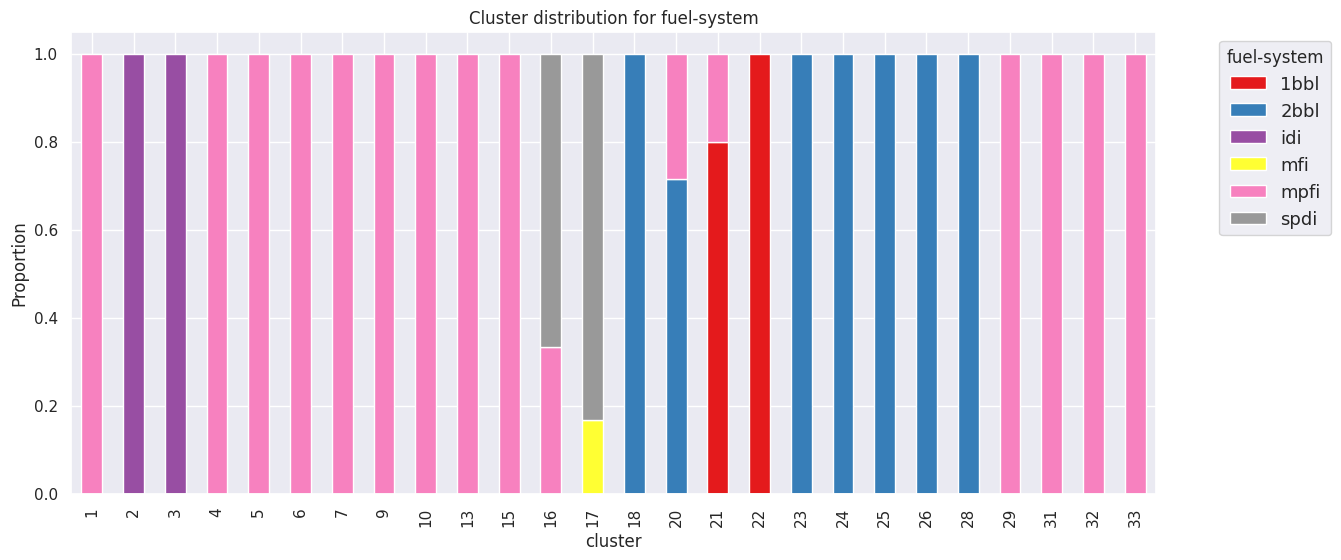

Internal diameter of each cylinder in the engine, measured in inches


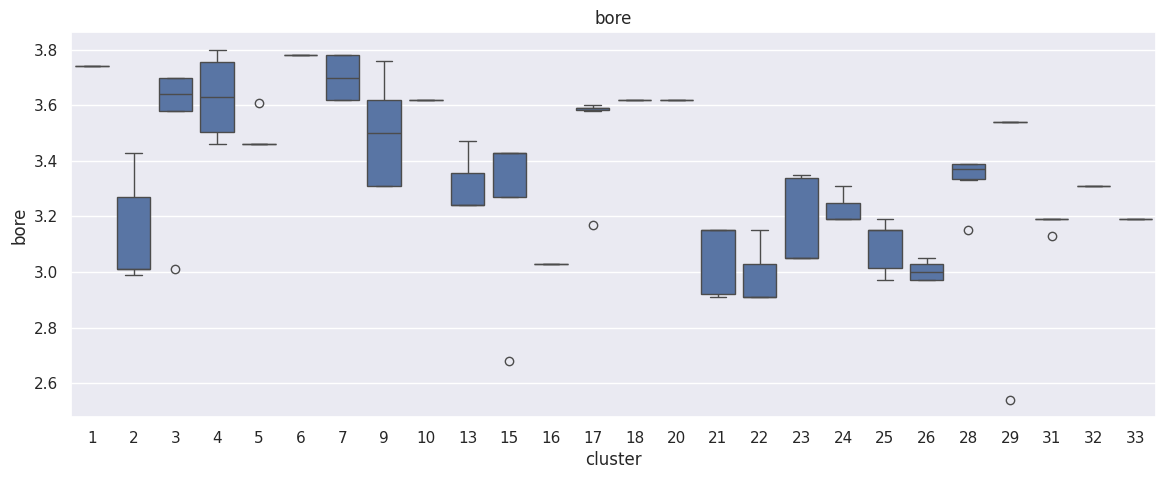

Travel distance of the piston within the engine cylinder, measured in inches


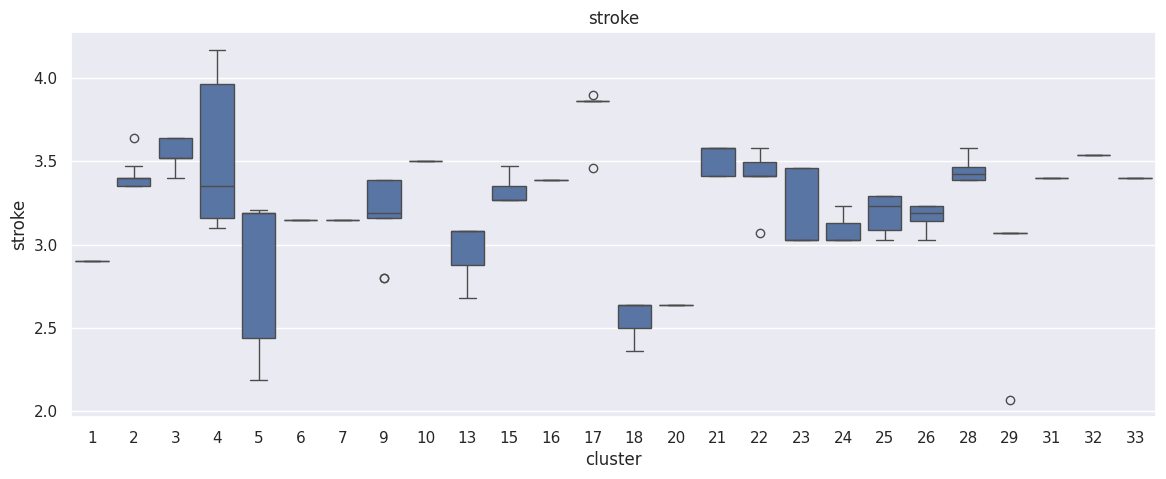

Volume ratio between piston positions at the bottom and top of its stroke


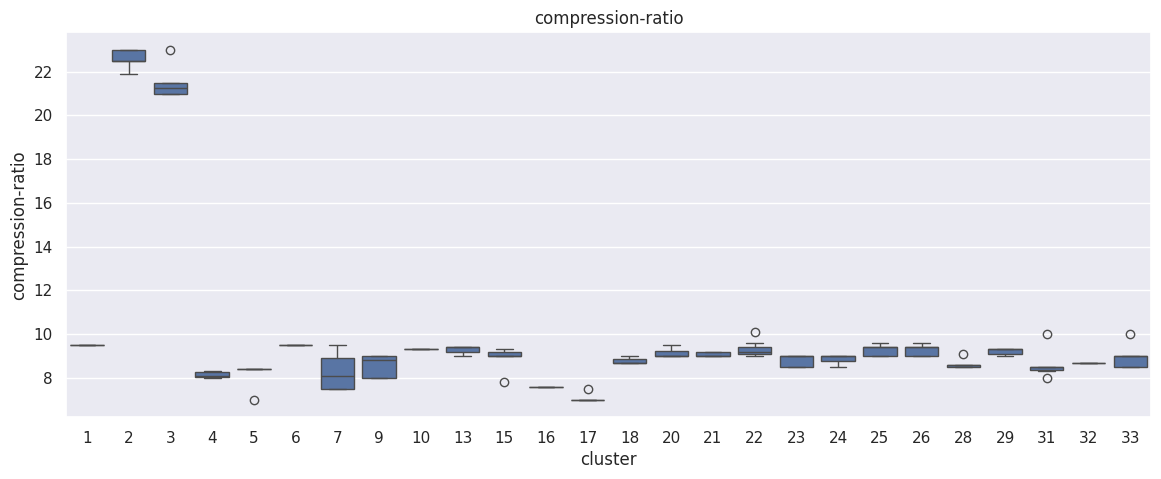

Engine power output, measured in horsepower


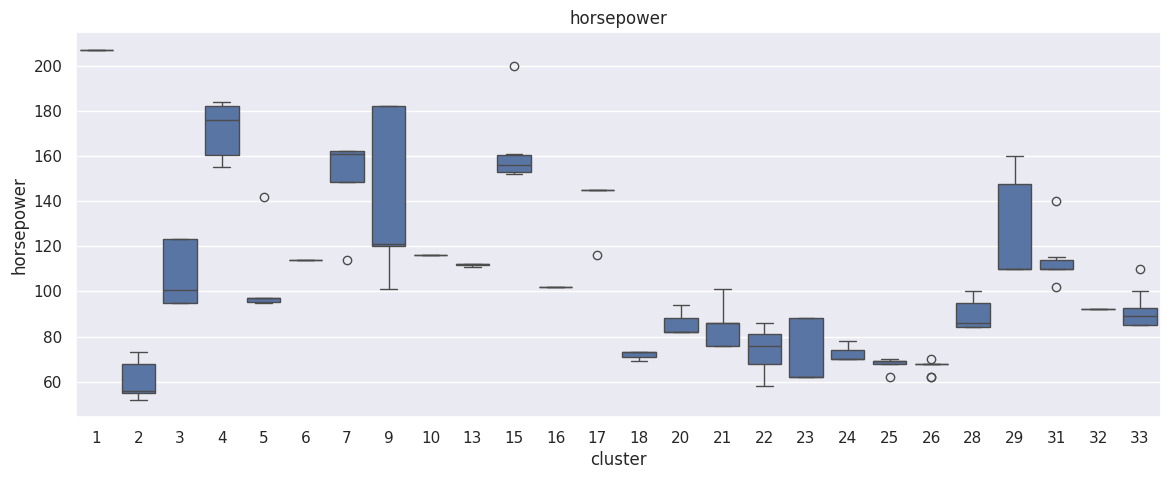

Engine speed at which maximum power output is achieved, measured in RPM


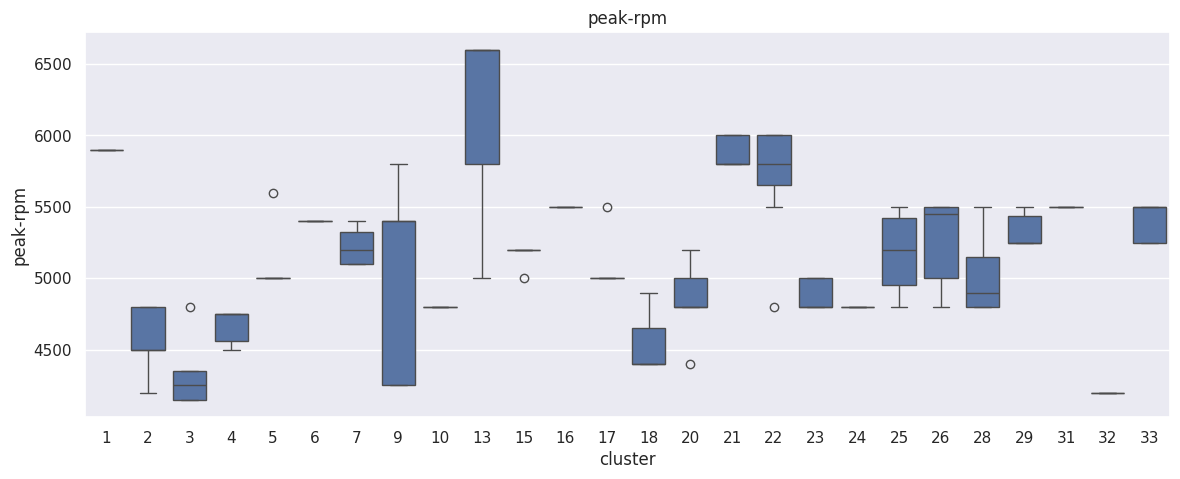

Fuel efficiency during city driving, measured in miles per gallon


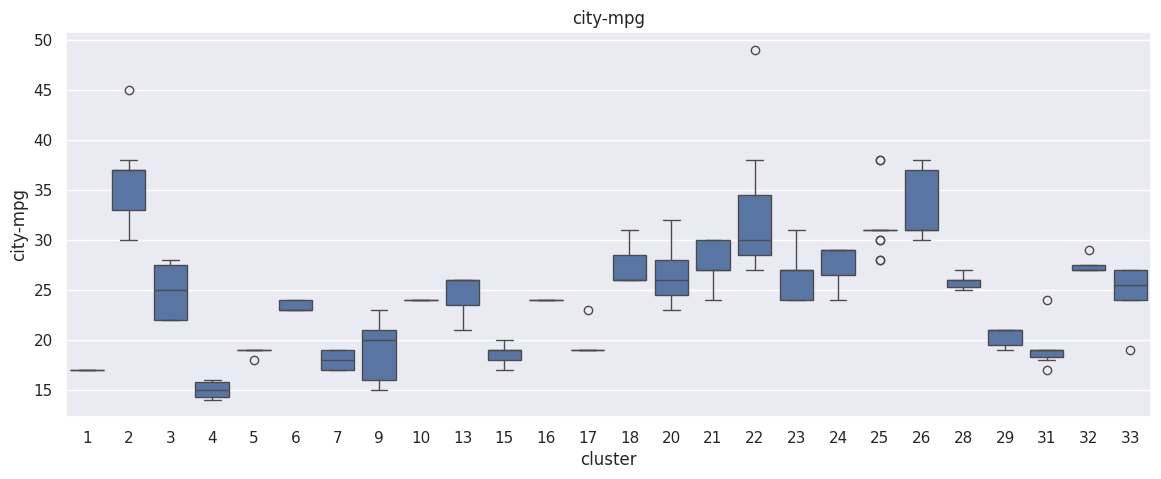

Fuel efficiency during highway driving, measured in miles per gallon


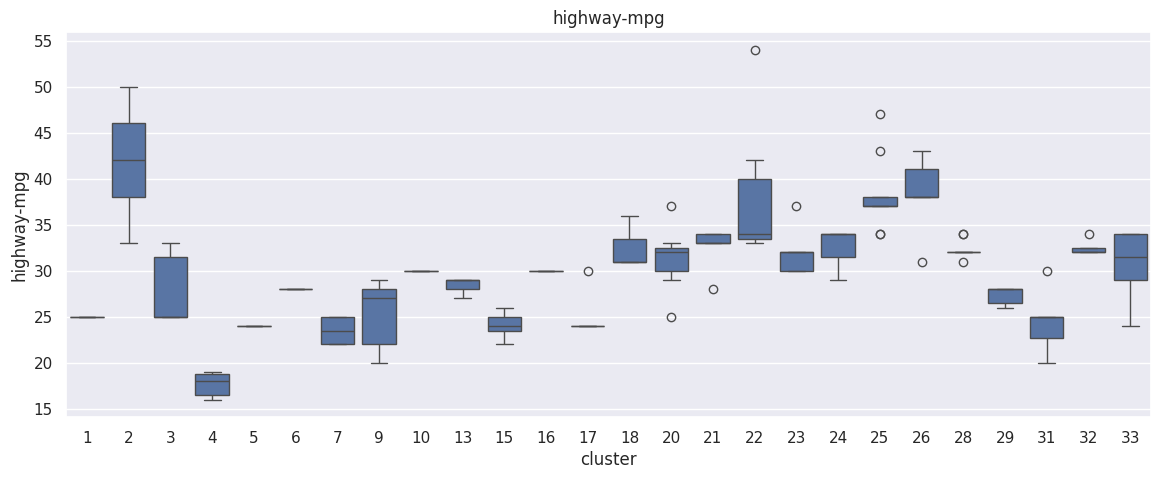

Market price of the car, usually provided in USD


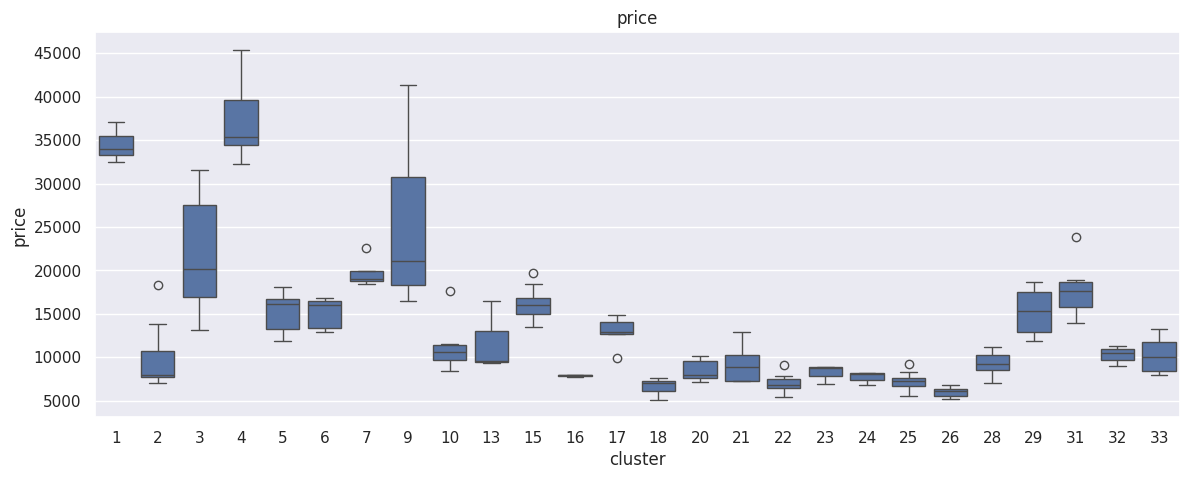

Categorical representation of car price for easier analysis or visualization


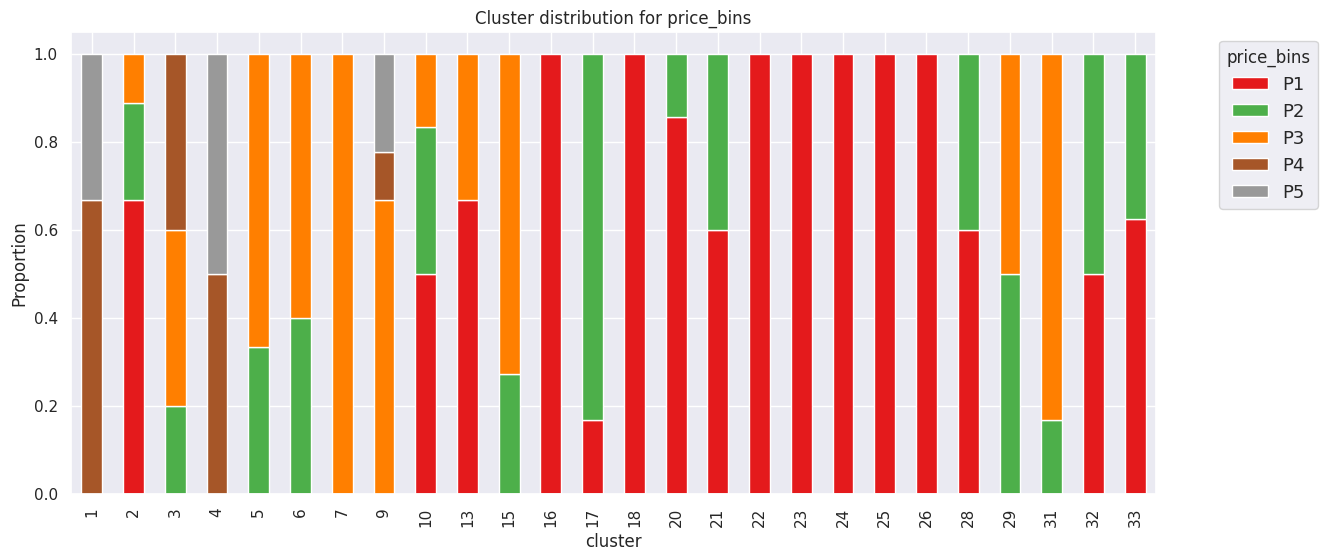

In [45]:
car_sec_info = car_sec_info[car_sec_info['cluster'].isin(keep_clust)]
numeric_col_names = car_sec_info.select_dtypes(include=[np.number]).columns.tolist()

# Plot cluster feature values
for feature in car_sec_info.columns:
    if feature != 'cluster':
        print(CAR_85_COLUMN_DESCRIPTION[feature])

        if feature in numeric_col_names:
            plt.figure(figsize=(14,5))
            sns.boxplot(car_sec_info, x='cluster', y=feature)
            plt.title(feature)
            plt.show()
        else:
            proportions = car_sec_info.groupby(
                'cluster'
            )[feature].value_counts(
                normalize=True
            ).unstack()

            if proportions.shape[1] > 15:
                # Create stacked bar plot
                ax = proportions.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='hsv')
                plt.title(f'Cluster distribution for {feature}')
                plt.ylabel('Proportion')

                # Define hatch patterns
                patterns = ["|" , "\\" , "/" , "+" , "-", ".", "*","x", "o", "O" ]

                # Apply hatch patterns
                for i, bar_container in enumerate(ax.containers):
                    hatch = patterns[i % len(patterns)]  # Cycle through patterns
                    for bar in bar_container:
                        bar.set_hatch(hatch)
            else:
                # Create stacked bar plot
                ax = proportions.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set1')
                plt.title(f'Cluster distribution for {feature}')
                plt.ylabel('Proportion')

            # Add legend
            plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

            # Get category labels
            category_labels = proportions.columns.tolist()[::-1]
            plt.show()